<a href="https://colab.research.google.com/github/cvillarr123/marketingKPI/blob/main/PROYECTO_SEE_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Programa  Ciencia de Datos 2021**
---
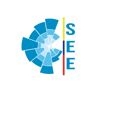
**Clasificación de anuncios publicitarios en Facebook Ads**

**Introducción**


El uso de las redes sociales ha incrementado notablemente en los últimos años, convirtiéndose en un instrumento de comunicación para las empresas. 

Facebook es considerada la red social social más popular, y con mayor penetración de usuarios. Además tiene a disposición la plataforma Facebook Ads, donde las empresas pueden crear publicaciones y llegar a un público donde pueda captar nuevos clientes a un costo menor, en comparación con las publicidades en canales tradicionales (TV, radio, prensa y otros).

A raiz del Covid-19, se tiene que la población en general ha incrementado el uso internet y de plataformas digitales, además de haber incrementado la compra de productos o servicios por el canal online. Por esta razón, las empresas han visto como aliado a las redes sociales, donde pueden mantener presencia, dar a conocer sus productos o servicios, además de crear vinculos y relaciones de confianza con sus públicos.

**Problema**


Cuando armamos campañas de marketing, necesitamos conseguir buenos resultados a un costo bajo. Existen varios objetivos de pauta en Facebook Ads, en este anuncio se analizará en conseguir clientes potenciales o llamados leads.


El problema radica en conocer cuales anuncios están siendo efectivos. Es decir llegar a la mayor cantidad de público a bajo costo, y así optimizar y conseguir los resultados planificados. 

**Objetivo**

Realizar la clasificación de anuncios publicitarios a través de un modelo de machine learning para optimizar las publicaciones de campañas en redes sociales basado en información histórica.






#**1.- Importación de data y explicación de las variables y tablas**

---



In [ ]:
#1.1.-Instalacion de de Librerias 

#Activar si no lo tienen instalada
#!pip uninstall scikit-learn -y
#!pip install -U pycaret scikit-learn
#!pip install shap
#!pip install kneed
#!pip install json

#0.- Librerias 
from google.colab import drive
#auth.authenticate_user()
from oauth2client.client import GoogleCredentials
#gc = gspread.authorize(GoogleCredentials.get_application_default())
drive.mount('/content/drive')
#import pycaret
#print('Using PyCaret Version', pycaret.__version__)
#print('Path to PyCaret: ', pycaret.__file__)
import warnings
import json
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from scipy import interp
from sklearn.model_selection import train_test_split


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#1.2.- Lectura de la base de datos

path='/content/drive/My Drive/PROYECTO DATA SCIENCE/Data/DATA DRIVE.xlsx' 
data = pd.read_excel(path,sheet_name='EDAD Y GENERO')
#path='DATA DRIVE.xlsx'
#data = pd.read_excel(path,sheet_name='EDAD Y GENERO')
data.info()


Descripción de las variables de estudio 

1. Year: Año de pauta (int64)  
2. Year & month: Año y mes de pauta (string) 
3. Month: Mes de pauta (string) 
4. Campaign ID: Identificador de la campaña (int64)  
5. Campaign name: Nombre de la campaña (string) 
6. Campaign objective: Objetivo de la campaña (string) 
7. Ad set ID: Identificador del conjunto de anuncios (int64)  
8. Ad set name: Nombre del conjunto de anuncios (string) 
9. Ad ID: Identificador del anuncio (int64)  
10. Ad name: Nombre del anuncio (string)     
11. Promoted post type: Tipo de publicación (string)      
12. Promoted post created date: Fecha de creación de la publicación (int64) 
13. Promoted post description: Descripción de la publicación (string) 
14. Promoted post message: Mensaje de la publicación (string) 
15. Promoted post caption: Título de la publicación (string)  
16. Ad set start time: Fecha de inicio del conjunto de anuncios (int64) 
17. Ad set end time: Fecha de finalización del conjunto de anuncios (int64)         
18. Ad set targeting: Segmentación por conjuntos de anuncios (string)
19. Targeting minimum age: Edad mínima de la segmentación (int64)  
20. Targeting maximum age: Edad máxima de la segmentación (int64) 
21. Age: Rango de edad del usuario (string)      
22. Gender: Sexo del usuario (string)      
23. Cost: Precio del anuncio (int64) 
24. Impressions: Número total de exposiciones del anuncio (int64)
25. Reach: Número de usuarios únicos que vieron un anuncio en su dispositivo (int64)
26. Frequency: Número de veces que se presentó el anuncio a la población alcanzada (int64)       
27. Link clicks: Número de clicks en la publicación (int64)  
28. Unique leads: Número de clicks en la publicación de usuarios únicos (int64)     
29. CPM (cost per 1000 impressions): Costo por 1000 exposiciones del anuncio (int64)
30. Cost per on-Facebook lead: Costo por cliente potencial (int64)    




**2.-Manipulacion de los datos**

---


In [ ]:
#2.1.- Filtración del año de estudio y un solo objetivo (LEAD_GENERATIO)
filter1 = data.Year == 2021  
filter2 = data.Age != 'unknown'
filter3 = data.Gender != 'unknown'
filter4 = data["Campaign objective"] == "LEAD_GENERATION"
data = data[  filter1 & filter2 & filter3 & filter4 ]

#2.2.- Eliminar registros que no tienen información del Costo por Lead y del campo Promoción por descripción
data=data.dropna(subset = ["Cost per on-Facebook lead"])
data=data.dropna(subset = ["Promoted post description"])
missing_values_count = data.isnull().sum()
missing_values_count[0:43]

#3.3.- Etiquetado Manual a priori de las promociones etiquetadas como buenas, malas y regulares, en base a los cuartiles Q1 y Q3 del Costo por Facebook lead
data =data.dropna(subset=["Cost per on-Facebook lead"])
q1= np.percentile(data["Cost per on-Facebook lead"], 25)  
q2= np.percentile(data["Cost per on-Facebook lead"], 50)
q3= np.percentile(data["Cost per on-Facebook lead"], 75) 

data['Clasificacion'] = "Ninguno"
data['ClasificacionDes'] = 'Ninguno'
data['Clasificacion'].loc[(data['Cost per on-Facebook lead']<= q1)] = 2  #"Mejores bajo costo"
data['Clasificacion'].loc[(data['Cost per on-Facebook lead']> q1 ) & (data['Cost per on-Facebook lead'] <= q3)] = 1 # "Regulares"
data['Clasificacion'].loc[(data['Cost per on-Facebook lead']> q3 )] = 0 #"Peores"
data['ClasificacionDes'].loc[(data['Cost per on-Facebook lead']<= q1)] = "Mejores bajo costo"
data['ClasificacionDes'].loc[(data['Cost per on-Facebook lead']> q1 ) & (data['Cost per on-Facebook lead'] <= q3)] = "Regulares"
data['ClasificacionDes'].loc[(data['Cost per on-Facebook lead']> q3 )] = "Peores"
data['Clasificacion']= data['Clasificacion'].astype('int')

#3.4.- Poner nombres más cortos sobre los mensajes configurados en las Publicidades para captar Leads
data['Descripcion'] = data['Promoted post description'] 
data['Message'] = data['Promoted post message'] 
data['Caption'] = data['Promoted post caption'] 
data['NumDescripcion'] = data.Descripcion.str.split().str.len()
data['NumMessage'] = data.Message.str.split().str.len()
data['NumCaption'] = data.Caption.str.split().str.len()

#3.5.- Crear rate o indicadores adicionales  
data['Rate'] = data['Unique leads']/data['Reach'] 
data['CTR'] = data['Link clicks']/data['Impressions'] 

In [ ]:
#3.6.- Creacion de variables categoricas del campo intereses
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore')
data['intereses'] = '0' 
data['ComprasOnline'] = '0'
data['Seguridad'] = '0'
data['SeguridadAlarmas'] = '0'
data['DispositivoInteligente'] = '0'
data['DispositivosGPS'] = '0'
data['SmartTechnologies'] = '0'
data['TarjetasCredito'] = '0'
data['Transporte'] = '0'
data['Vehiculos'] = '0'
ComprasOnline = ['Compras online']
Seguridad = ['Seguridad', 'Security', 'Sistema de alarma']
SeguridadAlarmas = ['Anti-theft system', 'Security alarm', 'Sistema de alarma']
DispositivoInteligente = ['Dispositivo inteligente']
DispositivosGPS = ['Dispositivos GPS','GPS Asistido','Conducción','Google Maps','Vehicle tracking system']
SmartTechnologies = ['Smart Technologies']
TarjetasCredito = ['Tarjetas de crédito']
Vehiculos = ['Sector automotor','Vehículos','Automóviles','Carros','Chevrolet','Dispositivos GPS','Honda','Mantenimiento preventivo','Motocicletas','Seguridad vial','Tarjetas de crédito','Toyota','Volkswagen']
Transporte = ['Transporte']

for i in data.index:

  #if (i == 3):
    campo_json = json.loads(data.loc[i]['Ad set targeting'])
    #print(campo_json)
    #hay registros que no tienen en el json el flexible_spec
    try:
        lista_intereses = pd.get_dummies(pd.json_normalize( campo_json ,record_path=['flexible_spec','interests'],errors='ignore').rename(columns={'name': 'interes'})['interes']).columns.values.tolist()
        #lista_educacion = pd.json_normalize(cuack_json,record_path=['flexible_spec'],errors='ignore')['education_statuses'][0]
        cadena_interes = '| ' + ''.join([  str( item + ' | ') for item in lista_intereses ])
        #print(cadena_interes)
        #cadena_educacion = '| ' + ''.join([  str( str(item) + ' | ') for item in lista_educacion ])
        data['intereses'][data.index == i] = cadena_interes

        if any(x in cadena_interes  for x in ComprasOnline) :
             data['ComprasOnline'][data.index == i] = '1'
        else :
             data['ComprasOnline'][data.index == i] = '0'

        if any(x in cadena_interes for x in Seguridad ) :
             data['Seguridad'][data.index == i] = '1'
        else :
             data['Seguridad'][data.index == i] = '0'

        if any(x in cadena_interes  for x in SeguridadAlarmas) :
             data['SeguridadAlarmas'][data.index == i] = '1'
        else :
             data['SeguridadAlarmas'][data.index == i] = '0'

        if any(x in cadena_interes  for x in DispositivoInteligente ) :
             data['DispositivoInteligente'][data.index == i] = '1'
        else :
             data['DispositivoInteligente'][data.index == i] = '0'

        if any(x in cadena_interes  for x in DispositivosGPS ) :
             data['DispositivosGPS'][data.index == i] = '1'
        else :
             data['DispositivosGPS'][data.index == i] = '0'

        if any(x in cadena_interes  for x in SmartTechnologies ) :
             data['SmartTechnologies'][data.index == i] = '1'
        else :
             data['SmartTechnologies'][data.index == i] = '0'

        if any(x in cadena_interes  for x in TarjetasCredito ) :
             data['TarjetasCredito'][data.index == i] = '1'
        else :
             data['TarjetasCredito'][data.index == i] = '0'

        if any(x in cadena_interes  for x in Transporte ) :
             data['Transporte'][data.index == i] = '1'
        else :
             data['Transporte'][data.index == i] = '0'

        if any(x in cadena_interes  for x in Vehiculos ) :
             data['Vehiculos'][data.index == i] = '1'
        else :
             data['Vehiculos'][data.index == i] = '0'

    except:
        #print('no entra')
        data.loc[i]['intereses'] = '0' 
        #data.loc[i]['education_statuses'] = '0' 
        data.loc[i]['ComprasOnline'] = '0'
        data.loc[i]['Seguridad'] = '0'
        data.loc[i]['SeguridadAlarmas'] = '0'
        data.loc[i]['DispositivoInteligente'] = '0'
        data.loc[i]['DispositivosGPS'] = '0'
        data.loc[i]['SmartTechnologies'] = '0'
        data.loc[i]['TarjetasCredito'] = '0'
        data.loc[i]['Vehiculos'] = '0'
        data.loc[i]['Transporte'] = '0'

#Transformar a enteros

data['ComprasOnline'] = data['ComprasOnline'].astype('int')
data['Seguridad'] = data['Seguridad'].astype('int')
data['SeguridadAlarmas'] = data['SeguridadAlarmas'].astype('int')
data['DispositivoInteligente'] = data['DispositivoInteligente'].astype('int')
data['DispositivosGPS'] = data['DispositivosGPS'].astype('int')
data['SmartTechnologies'] = data['SmartTechnologies'].astype('int')
data['TarjetasCredito'] = data['TarjetasCredito'].astype('int')
data['Vehiculos'] = data['Vehiculos'].astype('int')
data['Transporte'] = data['Transporte'].astype('int')


#**2.- Análisis Exploratorio de datos**

Se revisan los estadísticos básicos de cada variable, para descartar los ids,  las etiquetas Targeting minimum age y Targeting maximum age, además se ve diferentes escalas en los datos  cuantitativos, por lo cual será necesario aplicar algún tipo de metodo de escalamiento.

In [ ]:
# Funcion para graficar el diagrama de barras 
def graficar_countplot ( datos, x_col, y_col, paleta ) :
  chart = sns.countplot(x=x_col, data=datos, palette=paleta)
  chart.set_xticklabels(chart.get_xticklabels(), fontsize=7)
  chart.set(xlabel=x_col, ylabel=y_col)
  plt.show()

def dibujar_box_plot(datos, x_col, y_col, orientacion) :
     sns.boxplot(y= datos[x_col] , x= datos[y_col], orient=orientacion)

def graficar_categorias_vs_objetivo(data, x_col, y_col, tipo_grafico) :
  if (len(tipo_grafico) >= 1 and tipo_grafico[0] == 1)  :
    fig2 = px.histogram(data, x=x_col, y=y_col, histfunc='sum', height=300,
                        title='Histograma')
    fig2.show()
  if (len(tipo_grafico) >= 2 and tipo_grafico[0] == 1)  :  
    fig1 = px.bar(data, x=x_col, y=y_col, height=300,
                  title='Grafico barras apiladas - Hover on individual items')
    fig1.show()

def boxplot(x,y,**kwargs):
    sns.boxplot(x=x,y=y)
    x=plt.xticks(rotation=90)

In [ ]:

def grafica_roc_multiclase (col_y, col_score,  lista_etiqueta, modelo) :
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_curve, auc
    from itertools import cycle
    from scipy import interp

    lw =2

    y = label_binarize( col_y, classes= lista_etiqueta)
    n_classes = y.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y[:, i], col_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), col_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])


    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='Curva ROC para clase {0} (area = {1:0.2f})'
                ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Característica Operativa del Receptor ROC multiclase para ' + modelo)
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
data.describe()

,Year,Month,Campaign ID,Ad set ID,Ad ID,Promoted post created date,Ad set start time,Ad set end time,Targeting minimum age,Targeting maximum age,Cost,Impressions,Reach,Frequency,Link clicks,Unique leads,CPM (cost per 1000 impressions),Cost per on-Facebook lead,Clasificacion,NumDescripcion,NumMessage,NumCaption,Rate,CTR,ComprasOnline,Seguridad,SeguridadAlarmas,DispositivoInteligente,DispositivosGPS,SmartTechnologies,TarjetasCredito,Transporte,Vehiculos
count,476.0,476.000000,4.760000e+02,4.760000e+02,4.760000e+02,476.000000,476.000000,4.0,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000
mean,2021.0,4.193277,2.384593e+16,2.384635e+16,2.384679e+16,44334.901261,44175.512605,44364.0,22.432773,56.138655,14.374370,7330.718487,4224.294118,1.541786,41.088235,5.735294,2.322668,2.383256,1.002101,6.792017,34.491597,5.676471,0.004501,0.009135,0.808824,0.497899,0.428571,0.401261,0.525210,0.401261,0.888655,0.401261,0.915966
std,0.0,2.025219,1.680774e+11,7.915021e+11,6.676882e+11,33.310228,103.190605,0.0,1.454466,9.925072,25.172324,13626.452709,7092.997162,0.432234,67.071655,9.044294,1.575707,1.769113,0.706359,3.097167,10.284067,2.326134,0.018485,0.015230,0.393641,0.500522,0.495392,0.490669,0.499889,0.490669,0.314889,0.490669,0.277730
min,2021.0,1.000000,2.384591e+16,2.384591e+16,2.384591e+16,44272.000000,44118.000000,44364.0,18.000000,44.000000,0.020000,4.000000,3.000000,1.000000,1.000000,1.000000,0.750000,0.020000,0.000000,1.000000,1.000000,1.000000,0.000232,0.001137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2021.0,2.000000,2.384591e+16,2.384591e+16,2.384615e+16,44327.000000,44118.000000,44364.0,21.000000,44.000000,1.867500,807.750000,568.000000,1.230000,5.000000,1.000000,1.530000,1.277500,1.000000,5.000000,30.000000,4.000000,0.000947,0.004347,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
50%,2021.0,4.000000,2.384591e+16,2.384591e+16,2.384664e+16,44327.000000,44118.000000,44364.0,23.000000,65.000000,4.920000,2607.500000,1696.500000,1.440000,15.000000,2.000000,1.955000,2.025000,1.000000,7.000000,31.000000,6.000000,0.001529,0.005932,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,2021.0,6.000000,2.384591e+16,2.384603e+16,2.384748e+16,44362.000000,44138.000000,44364.0,23.000000,65.000000,15.382500,8261.750000,5047.500000,1.712500,44.000000,6.000000,2.732500,3.100000,1.250000,7.000000,40.000000,7.000000,0.003013,0.009790,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,2021.0,7.000000,2.384775e+16,2.384805e+16,2.384808e+16,44399.000000,44396.000000,44364.0,25.000000,65.000000,214.980000,147944.000000,67398.000000,3.900000,516.000000,68.000000,27.500000,11.390000,2.000000,12.000000,56.000000,9.000000,0.333333,0.250000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


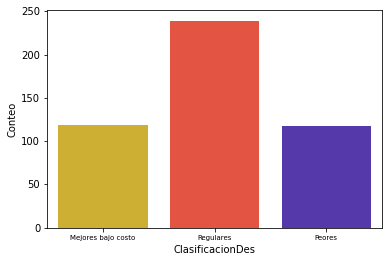

In [ ]:
graficar_countplot(data,'ClasificacionDes','Conteo','CMRmap_r')

In [ ]:
all_features = ['Targeting minimum age', 'Targeting maximum age', 'Age', 'Gender','Cost', 'Impressions', 'Reach', 'Link clicks', 'Unique leads','CPM (cost per 1000 impressions)', 'Cost per on-Facebook lead','NumDescripcion', 'NumMessage', 'NumCaption', 'Rate','CTR', 'education_statuses', 'ComprasOnline', 'Seguridad','SeguridadAlarmas', 'DispositivoInteligente', 'DispositivosGPS','SmartTechnologies', 'TarjetasCredito', 'Transporte']
categorical_columns_txt = ['Age', 'Gender']
categorical_columns_int = ['ComprasOnline', 'Seguridad','SeguridadAlarmas', 'DispositivoInteligente', 'DispositivosGPS','SmartTechnologies', 'TarjetasCredito', 'Transporte','Vehiculos']
categorical_columns = ['Age', 'Gender', 'ComprasOnline', 'Seguridad','SeguridadAlarmas', 'DispositivoInteligente', 'DispositivosGPS','SmartTechnologies', 'TarjetasCredito', 'Transporte','Vehiculos']
numerical_columns = ['Targeting minimum age', 'Targeting maximum age','NumDescripcion', 'NumMessage', 'NumCaption', 'Rate','CTR']
features_columns =  ['Targeting minimum age', 'Targeting maximum age','NumDescripcion', 'NumMessage', 'NumCaption', 'Rate','CTR','Age', 'Gender','education_statuses', 'ComprasOnline', 'Seguridad','SeguridadAlarmas', 'DispositivoInteligente', 'DispositivosGPS','SmartTechnologies', 'TarjetasCredito', 'Transporte']
labels = ['Clasificacion']

Realizando una revisión de las categorias generadas desde el campo **Intereses** contra la variable CostoPorFacebookLeads  (el código en el notebook adjunto).

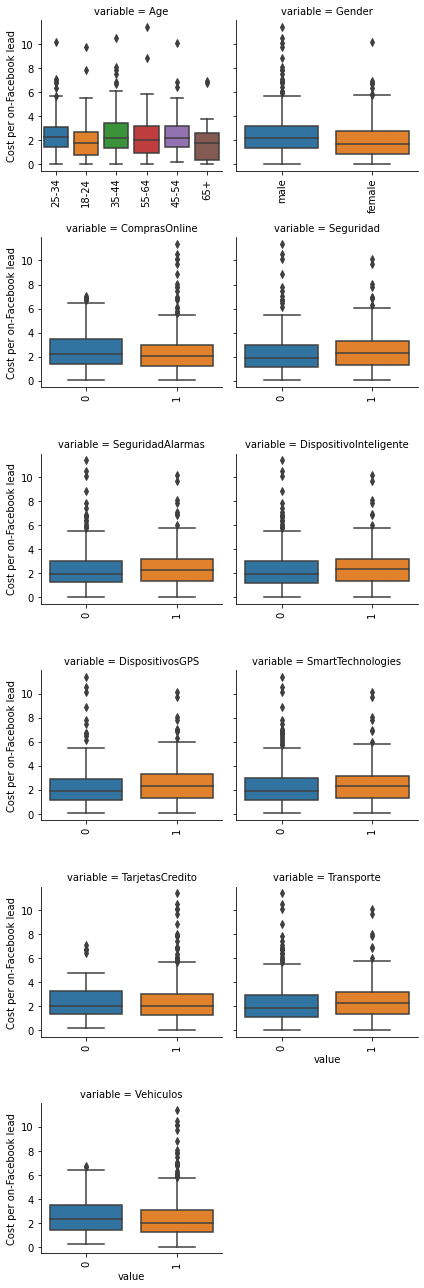

In [ ]:
f=pd.melt (data,id_vars=['Cost per on-Facebook lead'],value_vars=categorical_columns)
g=sns.FacetGrid(f,col='variable',col_wrap=2,sharex=False)
g.map(boxplot,'value','Cost per on-Facebook lead')

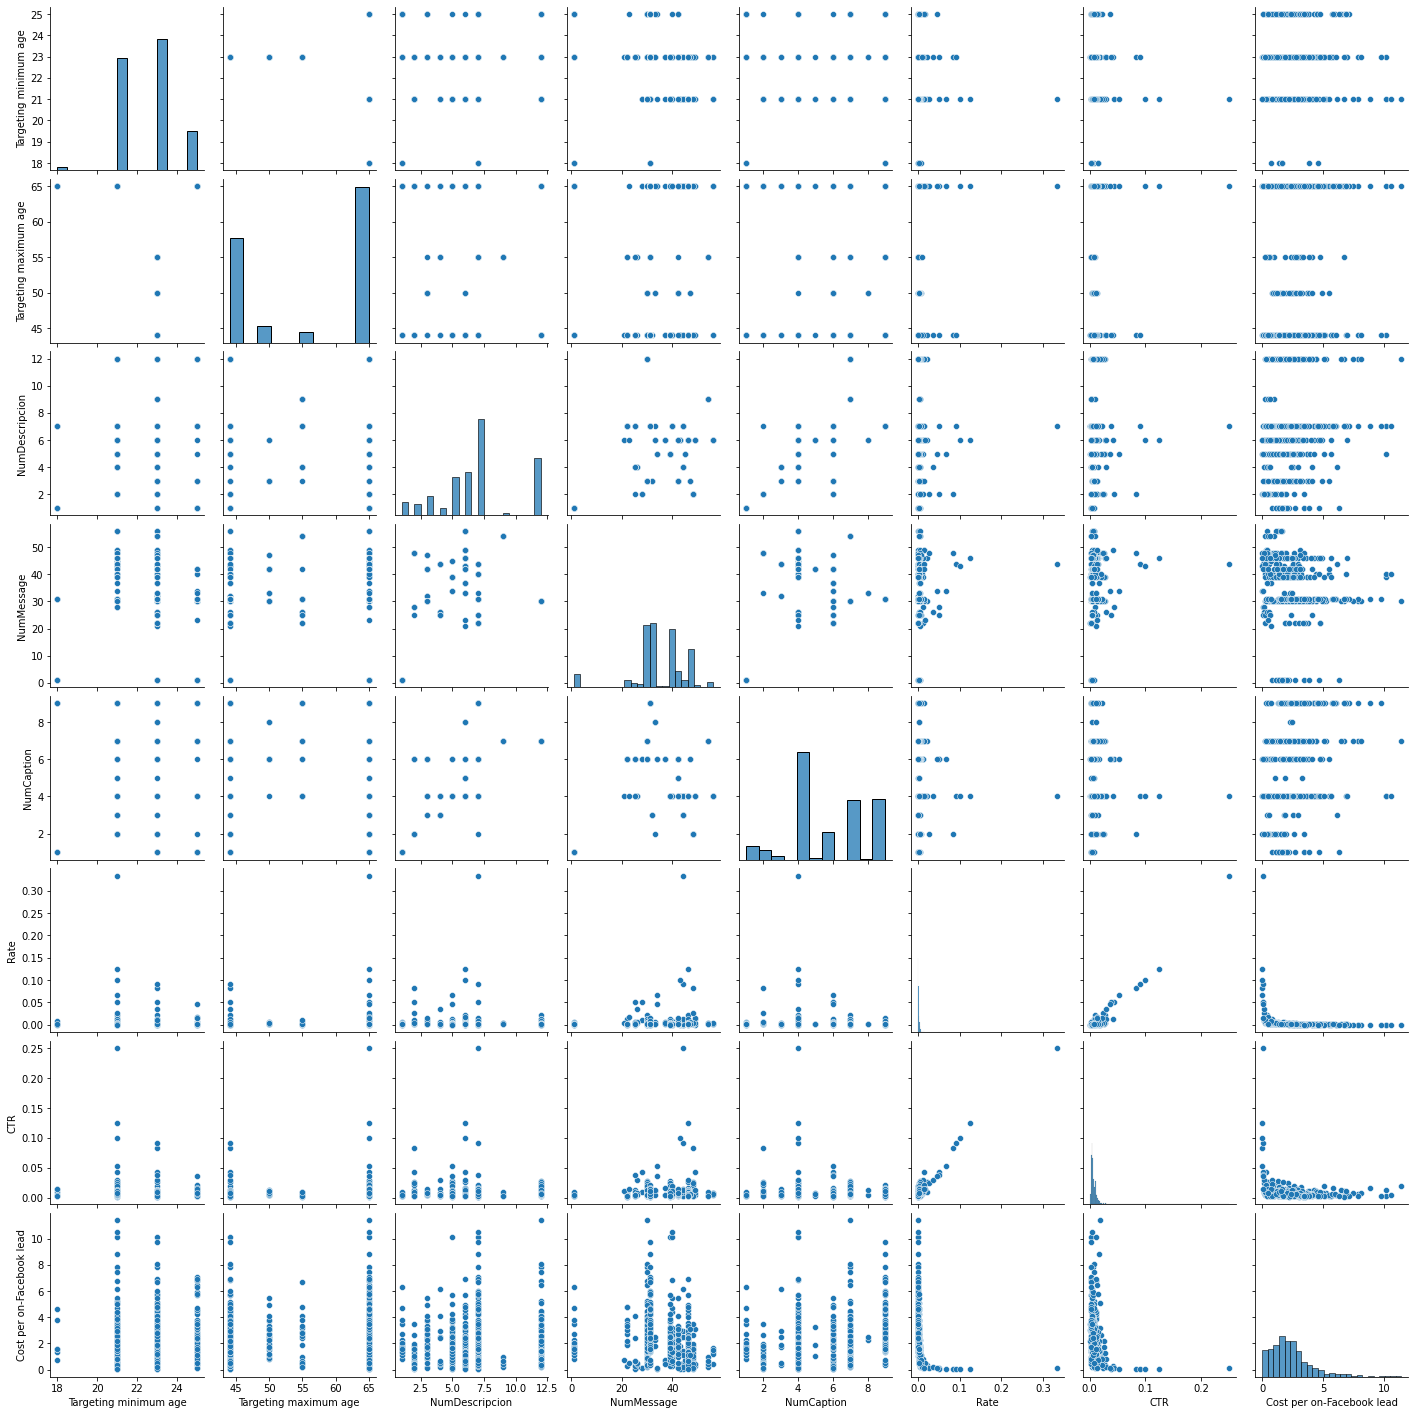

In [ ]:
sns.pairplot(data[[*numerical_columns,'Cost per on-Facebook lead']])

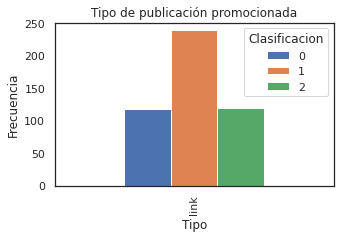

In [ ]:
pd.crosstab(data["Promoted post type"],data["Clasificacion"]).plot(kind="bar",figsize=(5,3))
plt.title('Tipo de publicación promocionada')
plt.xlabel('Tipo')
plt.ylabel('Frecuencia')
plt.savefig('heartDiseaseAndAges.png')
plt.show()

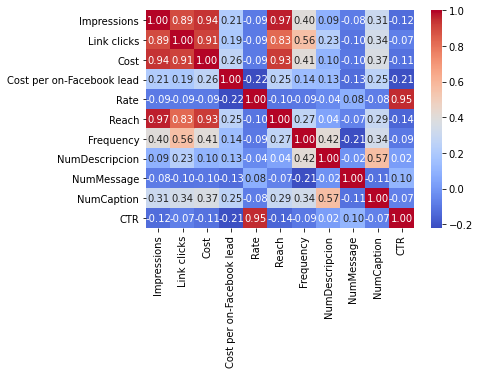

In [ ]:
numerical_columns = ["Impressions","Link clicks","Cost","Cost per on-Facebook lead","Rate","Reach","Frequency","NumDescripcion","NumMessage","NumCaption","CTR"]
g=sns.heatmap(data[numerical_columns].corr(),annot=True ,fmt=".2f", cmap="coolwarm")

Se observa un mayor número de leads cuando el número de palabras del Mensaje de la publicidad excede las 20 palabras.

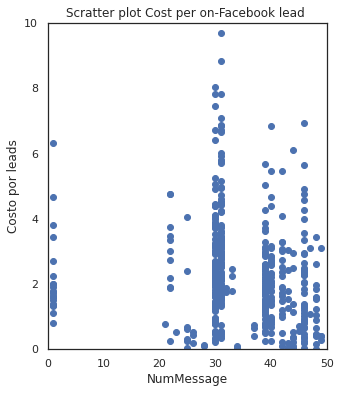

In [ ]:
plt.figure(figsize=(5,6))
plt.scatter(data['NumMessage'], data['Cost per on-Facebook lead']) # Display fraud amounts according to their time
plt.title('Scratter plot Cost per on-Facebook lead ')
plt.xlabel('NumMessage')
plt.ylabel('Costo por leads')
plt.xlim([0,50])
plt.ylim([0,10])
plt.show()

Se visualiza que las publicidades en Facebook con 4, 7 y 9 son las que tienen mayor distribución en los costos, se revisará con la etiqueta cuales son las menos costosas.

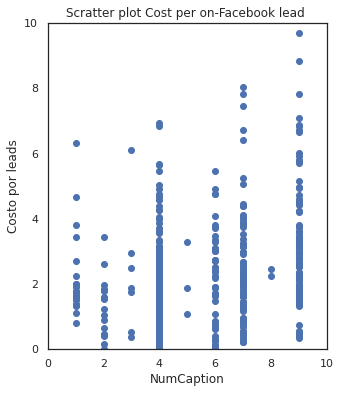

In [ ]:
plt.figure(figsize=(5,6))
plt.scatter(data['NumCaption'], data['Cost per on-Facebook lead']) # Display fraud amounts according to their time
plt.title('Scratter plot Cost per on-Facebook lead ')
plt.xlabel('NumCaption')
plt.ylabel('Costo por leads')
plt.xlim([0,10])
plt.ylim([0,10])
plt.show()

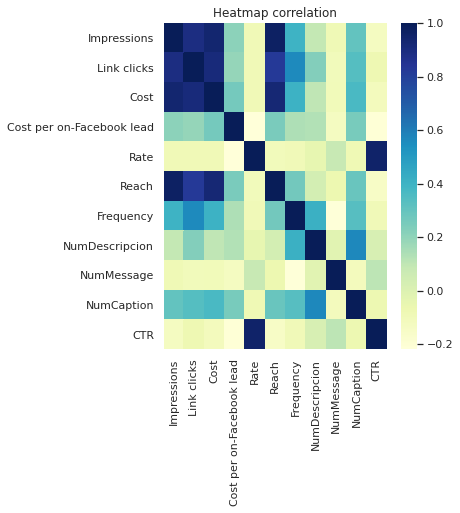

In [ ]:
import seaborn

df_corr = data[numerical_columns].corr() # Calculation of the correlation coefficients in pairs, with the default method:
plt.figure(figsize=(5,6))
seaborn.heatmap(df_corr, cmap="YlGnBu") 
seaborn.set(font_scale=1,style='white')

plt.title('Heatmap correlation')
plt.show()

Se revisa que no hay una diferencia en la distribución de las publicidades en el mes, se verá si hay algun patrón que identifique que características que poseen las que tienen el menor costo, y si hay algún mes en particular donde las publicidades tengan mejor perfomance.

A continuación se ve una relación del mes versus el costo por facebook lead 


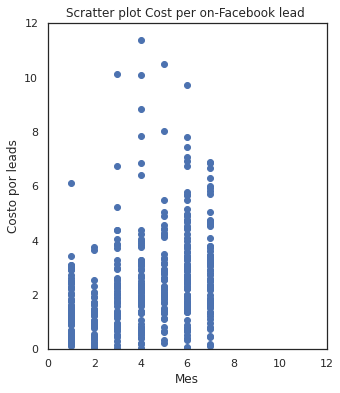

In [ ]:
plt.figure(figsize=(5,6))
plt.scatter(data['Month'], data['Cost per on-Facebook lead']) # Display fraud amounts according to their time
plt.title('Scratter plot Cost per on-Facebook lead ')
plt.xlabel('Mes')
plt.ylabel('Costo por leads')
plt.xlim([0,12])
plt.ylim([0,12])
plt.show()

Se muestra una distribución pareja en los rangos de edad, sin considerar si son buenas, regulares o malas.

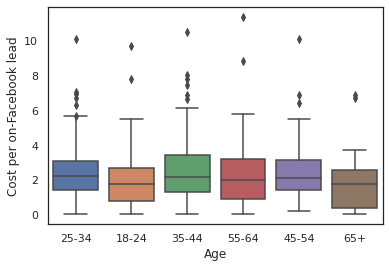

In [ ]:
dibujar_box_plot(data, 'Cost per on-Facebook lead', 'Age', 'v')

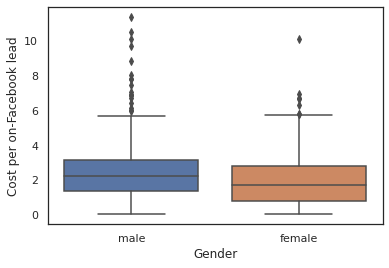

In [ ]:
dibujar_box_plot(data, 'Cost per on-Facebook lead', 'Gender', 'v')

# 3.- Modelo 1: Topic modelling 

El modelado de temas es un método para la clasificación no supervisada de documentos, similar al agrupamiento en datos numéricos.

¿Qué message se podrían utilizar para crear nuevos anuncios en Facebook?


In [ ]:
#3.1.- Instalacion de librerias 
#!pip install keras
from nltk.corpus import stopwords
from nltk.util import ngrams
from wordcloud import WordCloud
from collections import defaultdict
from collections import Counter
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
import torch
import warnings
warnings.simplefilter('ignore')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# 3.2.- Extracccion de los stopwords

stop = set(stopwords.words('spanish'))
def length(text):    
    '''a function which returns the length of text'''
    return len(text)
  
data['length'] = data['Promoted post message'].apply(length)

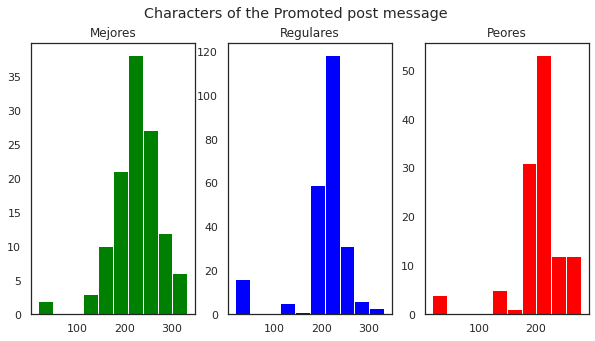

In [ ]:
fig,(ax0,ax1,ax2)=plt.subplots(1,3,figsize=(10,5))
data_len=data[data['Clasificacion']==2]['Promoted post message'].str.len()
ax0.hist(data_len,color='green')
ax0.set_title('Mejores')
data_len=data[data['Clasificacion']==1]['Promoted post message'].str.len()
ax1.hist(data_len,color='blue')
ax1.set_title('Regulares')
data_len=data[data['Clasificacion']==0]['Promoted post message'].str.len()
ax2.hist(data_len,color='red')
ax2.set_title('Peores')
fig.suptitle('Characters of the Promoted post message  ')
plt.show()

Se observa que los mejores anuncios tienen entre 100 a 300 caracteres.

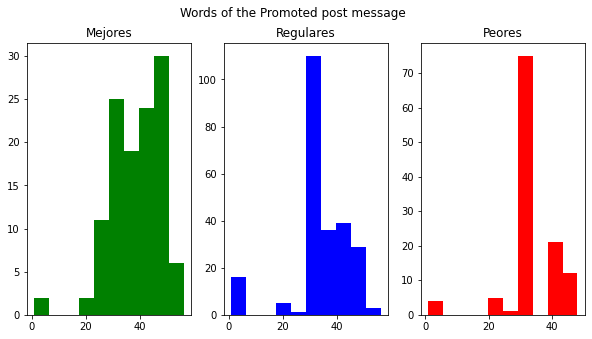

In [ ]:

fig,(ax0,ax1,ax2)=plt.subplots(1,3,figsize=(10,5))

data_len=data[data['Clasificacion']==2]['Promoted post message'].str.split().map(lambda x: len(x))
ax0.hist(data_len,color='green')
ax0.set_title('Mejores')

data_len=data[data['Clasificacion']==1]['Promoted post message'].str.split().map(lambda x: len(x))
ax1.hist(data_len,color='blue')
ax1.set_title('Regulares')

data_len=data[data['Clasificacion']==0]['Promoted post message'].str.split().map(lambda x: len(x))
ax2.hist(data_len,color='red')
ax2.set_title('Peores')


fig.suptitle('Words of the Promoted post message  ')
plt.show()

Se observa que los mejores anuncios tienen entre 2 a 50 caracteres.Mientras que olos resulares y malos en mayor porcentaje 30 caracteres.

In [ ]:
def create_corpus(Clasificacion):
    corpus=[]
    
    for x in data[data['Clasificacion']==Clasificacion]['Promoted post message'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [ ]:
def create_corpus_df(data, Clasificacion):
    corpus=[]
    
    for x in data[data['Clasificacion']==Clasificacion]['Promoted post message'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [ ]:
corpus= create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.title('stopwords comunes en Peores anuncios')
x,y=zip(*top)
plt.bar(x,y)

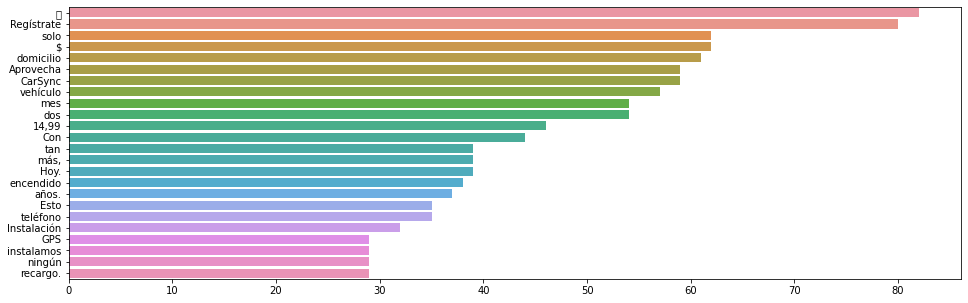

In [ ]:

# Top de palabras comunes en los mejores anuncios 

plt.figure(figsize=(16,5))
corpus=create_corpus(2)
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
        sns.barplot(x=y,y=x)


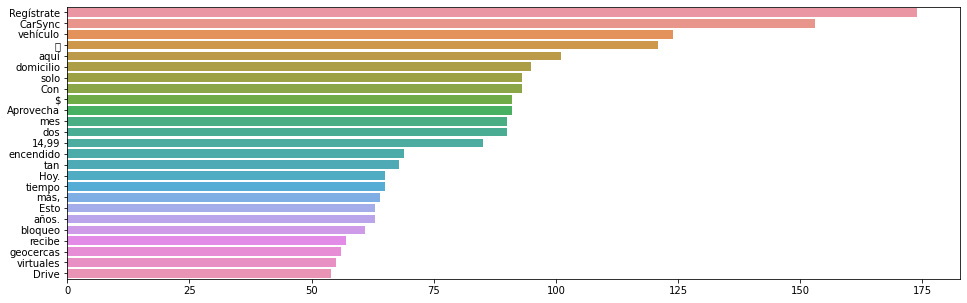

In [ ]:
# Top de palabras comunes en los anuncios regulares 
plt.figure(figsize=(16,5))
corpus=create_corpus(1)
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
        sns.barplot(x=y,y=x)

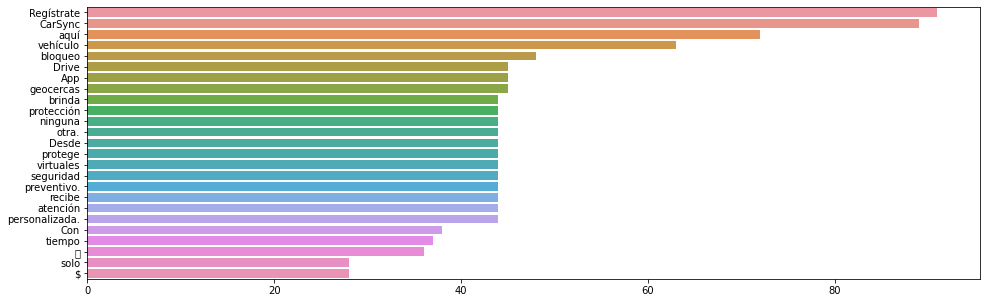

In [ ]:

# Top de palabras comunes en los peores anuncios 

plt.figure(figsize=(16,5))
corpus=create_corpus(0)
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
        sns.barplot(x=y,y=x)

De acuerdo a las tres gráficas, se observa que si se utilizan las mismas palabras tales como: regístrate o vehículo, domicilio, aprovecha y 14.99. Para hacer énfasis en los mejores anuncios las palabras que no están en los otros tipos de anuncios son: Teléfono, instalación, gps, ningún y recargo.

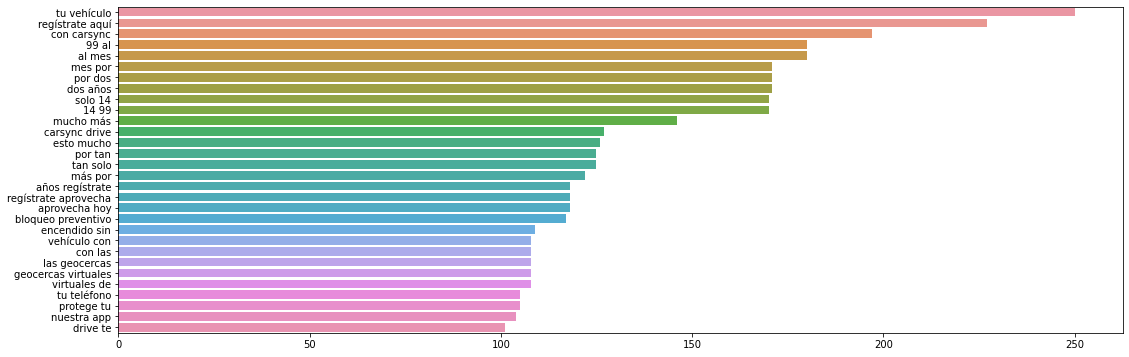

In [ ]:
# Bigramas de palabras en mejores publicaciones 

from sklearn.feature_extraction.text import CountVectorizer
corpus=create_corpus(2)
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

    plt.figure(figsize=(16,5))


top_tweet_bigrams=get_top_tweet_bigrams(data['Promoted post message'])[:30]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

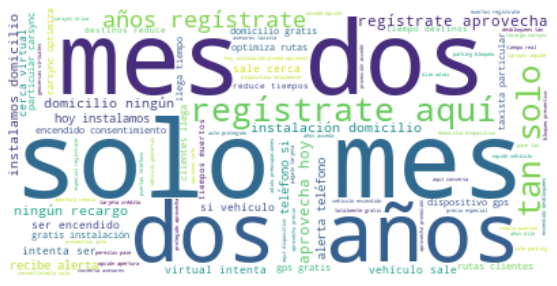

In [ ]:
# WordCloud

data_mejores= data[data['Clasificacion']==2]

text = ' '.join(data_mejores['Promoted post message'].str.lower())

wordcloud = WordCloud().generate(text)
wordcloud = WordCloud(stopwords=stop, background_color="white", max_words=1500).generate(text)
#wordcloud.most_common(20)
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

data= data[data['Clasificacion']==2]
data['message']=data['Promoted post message']
count_vect = CountVectorizer(stop_words=stop)
X_train_counts = count_vect.fit_transform(data.message)
X_train_counts.shape

(119, 236)

Prepare data for LDA Analysis

In [ ]:
# Librerias 

import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stop
#stop_words.extend(['from', 'subject', 're', 'edu', 'use']) # Se utiliza si hay algunas palabras que para la amrca son stopwords


#Funciones
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = data.message.values.tolist()
data_words = list(sent_to_words(data))

# Eliminar stopwords 

data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['seguridad', 'poder', 'recibir', 'asistencia', 'vial', 'momento', 'lugar', 'traves', 'app', 'movil', 'carsync', 'recibimos', 'todas', 'tarjetas', 'credito']


In [ ]:
import gensim.corpora as corpora
# Crear diccionario 
id2word = corpora.Dictionary(data_words)
# Crear Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1][0][:30])

from pprint import pprint
# Cantidad de topicos o cluster
num_topics = 5

# Construir LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]


In [ ]:
# Analizando los resultados  

import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Vizualizador de topicos  
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./'+str(num_topics))f
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
#Cargar los datos de pyLDAvis preparados previamente

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './'+ str(num_topics) +'.html')
LDAvis_prepared




PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.148512  0.076834       1        1  30.381789
3      0.242892 -0.005030       2        1  27.949327
4     -0.099411 -0.110834       3        1  15.559509
1     -0.012056 -0.032507       4        1  13.152930
2      0.017088  0.071537       5        1  12.956445, topic_info=           Term       Freq      Total Category  logprob  loglift
40  desbloquees  15.000000  15.000000  Default  30.0000  30.0000
43       impide  15.000000  15.000000  Default  29.0000  29.0000
26       gratis  46.000000  46.000000  Default  28.0000  28.0000
16         anos  51.000000  51.000000  Default  27.0000  27.0000
23          dos  52.000000  52.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
2       carsync   6.119214  59.323481   Topic5  -3.9219  -0.2280
17    aprovecha   5.765601  59.733088   Topic5  -3.9815  -0.2944
39          tan   4.778453  38.047324   Topic5  -4.1693  -0.0311
23          dos   5.005775  52.277831   Topic5  -4.1228  -0.3024
45          mas   4.356710  47.576012   Topic5  -4.2617  -0.3470

[285 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
15        1  0.456992     acceda
15        4  0.114248     acceda
15        5  0.456992     acceda
99        1  0.870219     accede
99        3  0.079111     accede
...     ...       ...        ...
58        3  0.053078    virtual
58        4  0.106155    virtual
58        5  0.265388    virtual
111       3  0.267916  virtuales
111       4  0.669790  virtuales

[404 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 5, 2, 3])

pyLDAvis está diseñado para ayudar a los usuarios a interpretar los temas en un modelo de tema que se ha ajustado a un corpus de datos de texto. El paquete extrae información de un modelo de tema LDA ajustado para informar una visualización interactiva basada en la web.



```
# Tiene formato de código
```

Estructura del grafico: 

* Cada burbuja representa un tema. Cuanto más grande es la burbuja, mayor  porcentaje de la cantidad de tweets en el corpus es sobre ese tema.

* Las barras azules representan la frecuencia general de cada palabra en el corpus. Si no se selecciona ningún tema, se mostrarán las barras azules de las palabras más utilizadas.

* Las barras rojas indican el número estimado de veces que un tema determinado generó un término determinado.

*  Cuanto más alejadas estén las burbujas, más diferentes serán. 

Un buen modelo de tema tendrá burbujas grandes y no superpuestas repartidas por todo el gráfico. Como podemos ver en el gráfico, las burbujas están agrupadas en distintos lugares. 



# 4.- Modelo 2: Clasificaciòn de anuncios 

## 4.1.- Seleccion de variables, data entrenamiento y test


In [ ]:
data.columns

Index(['Year', 'Year & month', 'Month', 'Campaign ID', 'Campaign name',
       'Campaign objective', 'Ad set ID', 'Ad set name', 'Ad ID', 'Ad name',
       'Promoted post type', 'Promoted post created date',
       'Promoted post description', 'Promoted post message',
       'Promoted post caption', 'Ad set start time', 'Ad set end time',
       'Ad set targeting', 'Targeting minimum age', 'Targeting maximum age',
       'Age', 'Gender', 'Cost', 'Impressions', 'Reach', 'Frequency',
       'Link clicks', 'Unique leads', 'CPM (cost per 1000 impressions)',
       'Cost per on-Facebook lead', 'Clasificacion', 'ClasificacionDes',
       'Descripcion', 'Message', 'Caption', 'NumDescripcion', 'NumMessage',
       'NumCaption', 'Rate', 'CTR', 'intereses', 'ComprasOnline', 'Seguridad',
       'SeguridadAlarmas', 'DispositivoInteligente', 'DispositivosGPS',
       'SmartTechnologies', 'TarjetasCredito', 'Transporte', 'Vehiculos',
       'length'],
      dtype='object')

## 4.2.- Preprocesamiento y split de train - test

In [ ]:
data_original = data.copy()
df= data.drop(['Year', 'Year & month', 'Campaign ID', 'Campaign name',
       'Campaign objective', 'Ad set ID', 'Ad set name', 'Ad ID', 'Ad name',
       'Promoted post type','Promoted post description', 'Promoted post message',
       'Promoted post caption', 'Ad set start time', 'Ad set end time',
       'Ad set targeting', 'Frequency', 'ClasificacionDes',
       'Descripcion', 'Message', 'Caption','Promoted post created date','intereses'], axis=1)


**Creating Dummy Variables**¶


No es necesario aplicar esto cuando se tiene el pipeline, ver esta referencia para variables categoricas enteras, por tanto no era necesario cambiarlas a entero,  en nuestro caso no trabajamos aún en pipeline debido a la extracción particular que se hizo sobre el campo complejo **intereses**.

https://www.it-swarm-es.com/es/python/preprocesamiento-de-funciones-de-variables-continuas-y-categoricas-de-tipo-entero-con-scikit-learn/830818857/

In [ ]:
a = pd.get_dummies(data['Gender'], prefix = "type")
b = pd.get_dummies(data['Age'], prefix = "type")

frames = [df,a,b]
df = pd.concat(frames, axis = 1)
df = df.drop(columns = ['Gender','Age'])
y = df.Clasificacion.values
x_data = df.drop(['Clasificacion'], axis = 1)

Escalar los datos con máximo y mínimo (de forma manual) 

In [ ]:
# Normalize
x = (x_data - np.min(x_data)) / (np.max(x_data) - np.min(x_data)).values
x.head(2)

Crear los datos para entrenamiento y de test

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state=0 , stratify=y)

## 4.3.- Creacion de modelos


## 4.3.1.- Pycaret

In [ ]:
np.random.seed(9)
train, test = train_test_split(df,test_size = 0.2,random_state=0)
#Eliminar Impresiones , Reach y link dado que estan ya el CTR y Rate, y dejar solo rate dado que con CTR hay una correlacion
train= train.drop(['Unique leads','Impressions', 'Reach', 'Link clicks','Cost','CTR','Cost per on-Facebook lead'],axis=1 )
test= test.drop(['Unique leads','Impressions', 'Reach', 'Link clicks','Cost','CTR','Cost per on-Facebook lead'],axis=1 )
print(train.columns)
print(test.columns)

In [ ]:
clf1 = setup(data =train,  
             target = 'Clasificacion')
            # numeric_imputation = 'mean'),
            #categorical_features = ['Gender','Age'])
            #ignore_features = ['Cost per on-Facebook lead','Unique leads'])
            # silent = True)       

In [ ]:
# Comparar modelos
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8600,0.9290,0.8426,0.8731,0.8568,0.7685,0.7765,0.112
gbc,Gradient Boosting Classifier,0.8345,0.9258,0.8096,0.8519,0.8285,0.7225,0.7341,0.313
dt,Decision Tree Classifier,0.7662,0.8022,0.7593,0.7840,0.7609,0.6206,0.6325,0.019
rf,Random Forest Classifier,0.7315,0.8778,0.6807,0.7533,0.7197,0.5415,0.5586,0.475
ada,Ada Boost Classifier,0.6796,0.8389,0.6090,0.7281,0.6563,0.4350,0.4744,0.105
et,Extra Trees Classifier,0.6416,0.7677,0.6038,0.6620,0.6338,0.4028,0.4163,0.464
lda,Linear Discriminant Analysis,0.5662,0.6942,0.5208,0.5723,0.5599,0.2770,0.2824,0.021
lr,Logistic Regression,0.5134,0.6676,0.4499,0.5097,0.4919,0.1692,0.1803,0.538
ridge,Ridge Classifier,0.5131,0.0000,0.4487,0.5067,0.4903,0.1679,0.1771,0.017
qda,Quadratic Discriminant Analysis,0.5054,0.5242,0.3560,0.4157,0.4026,0.0528,0.0829,0.023


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=7243, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## 4.3.1- Pycaret: Mejor modelo 1: gbc

In [ ]:
# Mejor modelo 
gbc_model  = create_model('gbc')      

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8889,0.9684,0.8730,0.8938,0.8894,0.8163,0.8183
1,0.9259,0.9538,0.9286,0.9312,0.9259,0.8797,0.8817
2,0.8519,0.8966,0.8730,0.8735,0.8567,0.7672,0.7742
3,0.8148,0.8792,0.7937,0.8315,0.8143,0.6925,0.6975
4,0.7037,0.7884,0.6190,0.7630,0.6854,0.4653,0.5094
5,0.8462,0.9583,0.8095,0.8606,0.8436,0.7347,0.7433
6,0.7692,0.9413,0.8022,0.7894,0.7740,0.6406,0.6466
7,0.7308,0.8074,0.7466,0.7356,0.7318,0.5748,0.5762
8,0.8462,0.9559,0.8376,0.8433,0.8422,0.7530,0.7548
9,0.7308,0.9144,0.7686,0.7462,0.7280,0.5882,0.5980


In [ ]:
# Ajuste
tuned_gbc = tune_model(gbc_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8889,0.9673,0.8968,0.8966,0.8911,0.8224,0.8243
1,0.8889,0.9372,0.9048,0.8913,0.8883,0.8224,0.8243
2,0.8889,0.9126,0.8968,0.8966,0.8911,0.8224,0.8243
3,0.7407,0.8327,0.7222,0.7645,0.7440,0.5695,0.5736
4,0.7407,0.7800,0.6508,0.8272,0.7078,0.5239,0.6003
5,0.8462,0.9718,0.8413,0.8571,0.8488,0.7451,0.7469
6,0.8077,0.9200,0.8199,0.8269,0.8117,0.6956,0.7005
7,0.6923,0.8389,0.6612,0.7324,0.6905,0.4889,0.4983
8,0.7308,0.8954,0.6709,0.6947,0.6883,0.5450,0.5656
9,0.7308,0.8658,0.7088,0.7264,0.7270,0.5614,0.5629


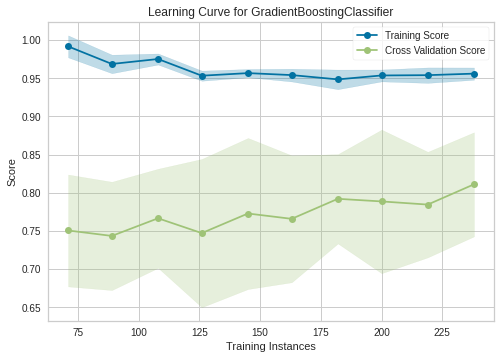

In [ ]:
#Learning Curve
plot_model(estimator = tuned_gbc, plot = 'learning')

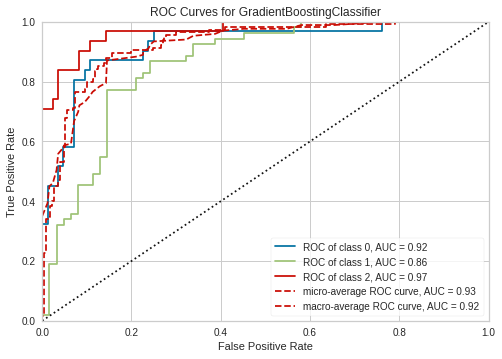

In [ ]:
# AUC Curve
plot_model(estimator = tuned_gbc, plot = 'auc')


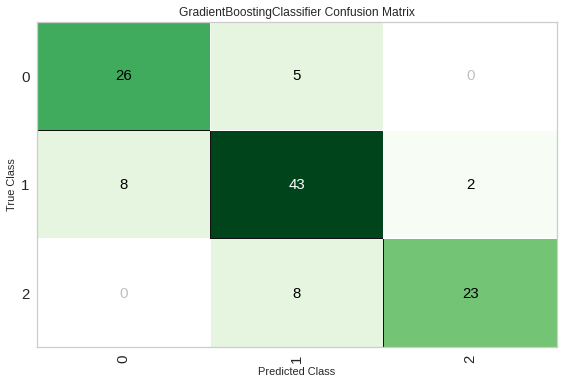

In [ ]:
#Confusion Matrix
plot_model(estimator = tuned_gbc, plot = 'confusion_matrix')

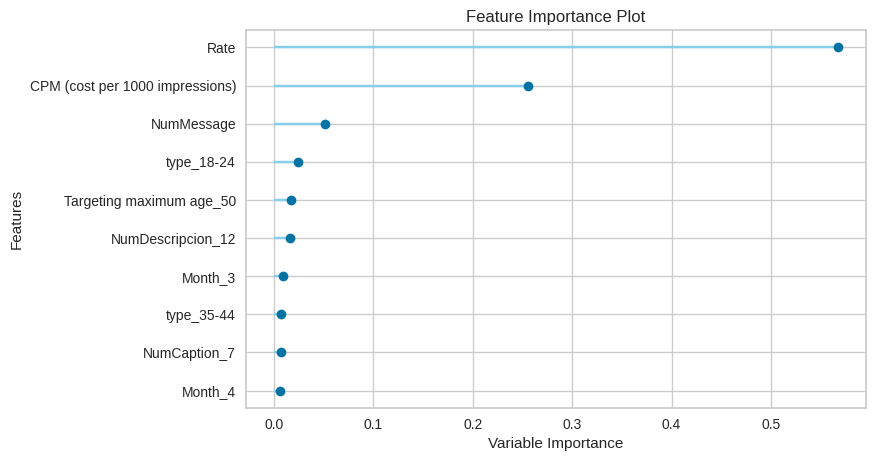

In [ ]:
#Feature Importance

plot_model(estimator = tuned_gbc, plot = 'feature')

##4.3.1- Pycaret: Mejor modelo 2: lightgbm 

In [ ]:
# Mejor modelo 
lightgbm_model  = create_model('lightgbm')      

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8889,0.9759,0.8730,0.8938,0.8894,0.8163,0.8183
1,0.8148,0.9413,0.8571,0.8418,0.8148,0.7140,0.7282
2,0.8519,0.9098,0.8730,0.8735,0.8567,0.7672,0.7742
3,0.7778,0.8735,0.7381,0.8056,0.7704,0.6241,0.6355
4,0.5556,0.7657,0.4921,0.5547,0.5426,0.2249,0.2328
5,0.8077,0.9436,0.7857,0.8346,0.7973,0.6750,0.6875
6,0.8846,0.9552,0.9011,0.8910,0.8862,0.8178,0.8197
7,0.7308,0.9031,0.7167,0.7341,0.7305,0.5614,0.5629
8,0.7692,0.9460,0.7265,0.7561,0.7467,0.6167,0.6285
9,0.7692,0.9273,0.7863,0.7765,0.7683,0.6414,0.6460


https://github.com/pycaret/pycaret/issues/516

In [ ]:
# Ajuste
tuned_lightgbm = tune_model(lightgbm_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8519,0.9666,0.8413,0.8519,0.8519,0.7589,0.7589
1,0.7778,0.9418,0.8016,0.7932,0.7798,0.6509,0.6567
2,0.8889,0.9080,0.8968,0.8966,0.8911,0.8224,0.8243
3,0.8148,0.8951,0.7937,0.8315,0.8143,0.6925,0.6975
4,0.6667,0.7920,0.5873,0.6830,0.6487,0.4073,0.4317
5,0.7692,0.9571,0.6984,0.8043,0.7592,0.5851,0.6108
6,0.8077,0.9422,0.8498,0.8423,0.8121,0.7045,0.7194
7,0.8077,0.8960,0.7900,0.8255,0.8074,0.6860,0.6912
8,0.8077,0.9462,0.7821,0.8015,0.7972,0.6860,0.6912
9,0.7692,0.8881,0.7863,0.7723,0.7644,0.6406,0.6466


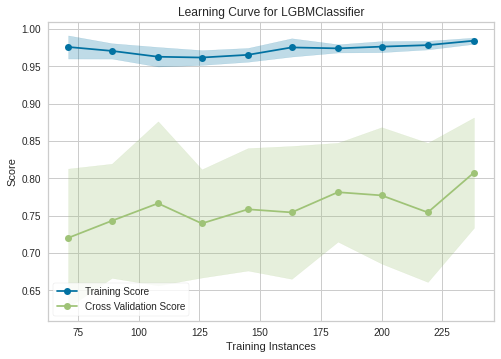

In [ ]:
#Learning Curve
plot_model(estimator = tuned_lightgbm, plot = 'learning')


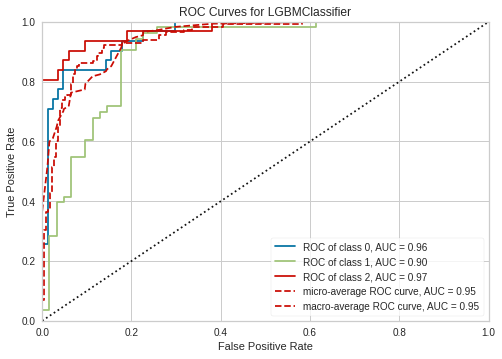

In [ ]:
# AUC Curve
plot_model(estimator = tuned_lightgbm, plot = 'auc')



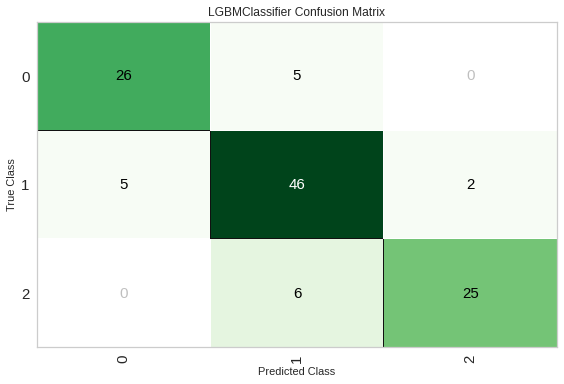

In [ ]:
#Confusion Matrix
plot_model(estimator = tuned_lightgbm, plot = 'confusion_matrix')


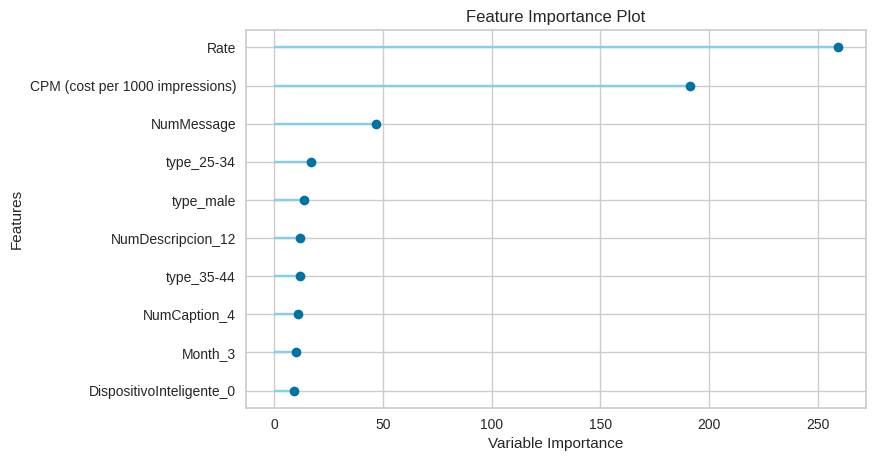

In [ ]:
#Feature Importance

plot_model(estimator = tuned_lightgbm, plot = 'feature')


In [ ]:
#Evaluar
evaluate_model(tuned_lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

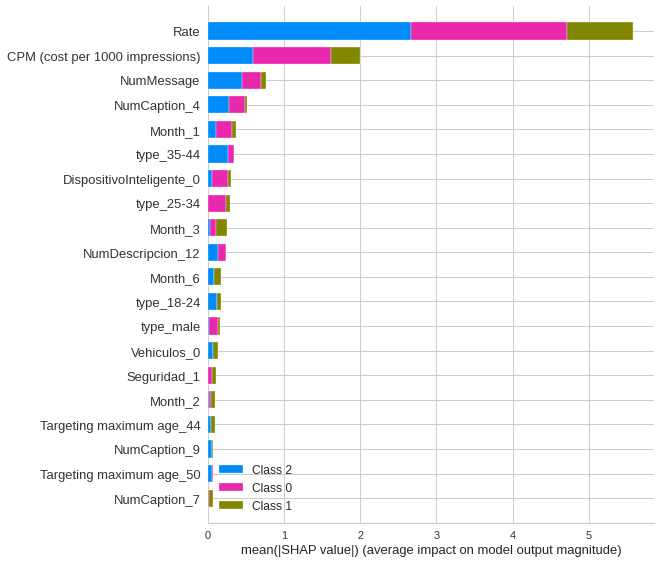

In [ ]:
#Interpretation
import shap

interpret_model(tuned_lightgbm)
#This function only supports tree based models for binary classification: dt, lightgbm, et, rf.

In [ ]:
#Predecir
predict_model(tuned_lightgbm, data=test)


,Month,Targeting minimum age,Targeting maximum age,CPM (cost per 1000 impressions),Clasificacion,NumDescripcion,NumMessage,NumCaption,Rate,ComprasOnline,Seguridad,SeguridadAlarmas,DispositivoInteligente,DispositivosGPS,SmartTechnologies,TarjetasCredito,Transporte,Vehiculos,type_female,type_male,type_18-24,type_25-34,type_35-44,type_45-54,type_55-64,type_65+,Label,Score
1518,4,21,65,2.35,2,12,30,7,0.004464,1,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,2,0.8661
1192,3,21,65,2.73,1,12,30,7,0.003020,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0.9085
1852,5,21,65,2.60,1,12,30,7,0.001838,1,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0.8627
2102,6,21,65,2.60,0,12,30,7,0.001016,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0.6066
632,2,21,65,1.22,2,5,39,4,0.001414,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0.9937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,4,23,44,2.47,1,12,30,7,0.001864,1,1,1,1,1,1,1,1,1,0,1,0,0,1,0,0,0,1,0.8677
2569,7,23,44,0.93,0,7,22,6,0.000381,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,0,0,0,0.5274
2826,7,23,55,1.26,0,7,22,6,0.000749,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0.6208
2390,6,25,65,7.22,2,6,23,4,0.017857,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,2,0.8816


In [ ]:
predictions = predict_model(tuned_lightgbm, data=test)
predictions.head()

,Month,Targeting minimum age,Targeting maximum age,CPM (cost per 1000 impressions),Clasificacion,NumDescripcion,NumMessage,NumCaption,Rate,ComprasOnline,Seguridad,SeguridadAlarmas,DispositivoInteligente,DispositivosGPS,SmartTechnologies,TarjetasCredito,Transporte,Vehiculos,type_female,type_male,type_18-24,type_25-34,type_35-44,type_45-54,type_55-64,type_65+,Label,Score
1518,4,21,65,2.35,2,12,30,7,0.004464,1,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,2,0.8661
1192,3,21,65,2.73,1,12,30,7,0.003020,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0.9085
1852,5,21,65,2.60,1,12,30,7,0.001838,1,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0.8627
2102,6,21,65,2.60,0,12,30,7,0.001016,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0.6066
632,2,21,65,1.22,2,5,39,4,0.001414,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0.9937


In [ ]:
## 3.0.1- Pycaret: Mejor modelo 2: lightgbm 

## 4.3.1- Pycaret: Mejor modelo 3: Decision Tree 

In [ ]:
# Mejor modelo 
dt_model  = create_model('dt')      

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8148,0.8505,0.8254,0.8197,0.8157,0.7039,0.7056
1,0.7778,0.8120,0.7778,0.7822,0.7778,0.6392,0.6406
2,0.8519,0.8901,0.8730,0.8735,0.8567,0.7672,0.7742
3,0.7037,0.7485,0.6905,0.6981,0.6990,0.5168,0.5179
4,0.5185,0.5843,0.4921,0.5136,0.5150,0.2023,0.2028
5,0.7692,0.7833,0.7302,0.7885,0.7692,0.6020,0.6091
6,0.8077,0.8441,0.8278,0.8157,0.8103,0.6963,0.6979
7,0.6923,0.7287,0.6612,0.7324,0.6905,0.4889,0.4983
8,0.8462,0.8718,0.8376,0.8433,0.8422,0.7530,0.7548
9,0.7308,0.7833,0.7387,0.7376,0.7328,0.5758,0.5772


In [ ]:
# Ajuste
tuned_dt = tune_model(dt_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5185,0.7220,0.4286,0.5322,0.5028,0.1460,0.1546
1,0.7407,0.8409,0.7222,0.7665,0.7462,0.5724,0.5764
2,0.5556,0.7096,0.5556,0.5412,0.5431,0.2987,0.3014
3,0.5556,0.7318,0.5476,0.5782,0.5593,0.2735,0.2760
4,0.4815,0.6565,0.4524,0.5000,0.4840,0.1250,0.1263
5,0.6154,0.7548,0.5079,0.6923,0.5719,0.2778,0.3131
6,0.3462,0.5178,0.2747,0.2618,0.2976,-0.1451,-0.1606
7,0.5385,0.6874,0.4548,0.6285,0.5027,0.1811,0.2015
8,0.4615,0.5931,0.4634,0.4643,0.4615,0.1395,0.1398
9,0.5769,0.6466,0.5324,0.5761,0.5683,0.2886,0.2944


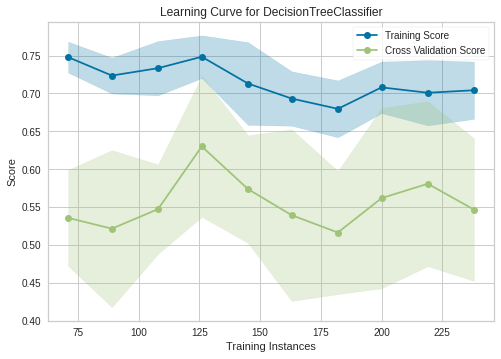

In [ ]:
#Learning Curve
plot_model(estimator = tuned_dt, plot = 'learning')


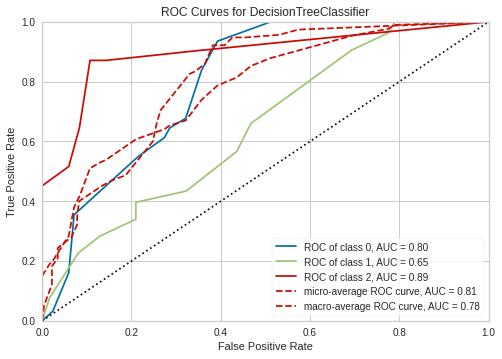

In [ ]:
# AUC Curve
plot_model(estimator = tuned_dt, plot = 'auc')


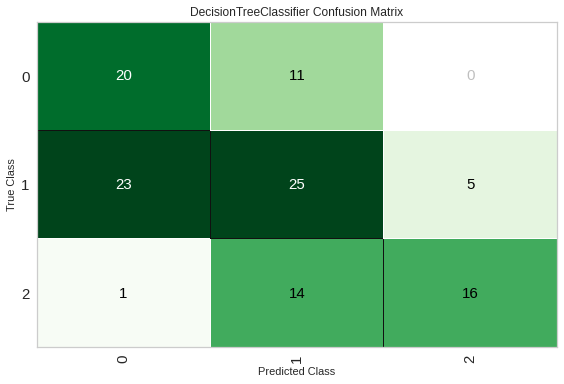

In [ ]:
#Confusion Matrix
plot_model(estimator = tuned_dt, plot = 'confusion_matrix')


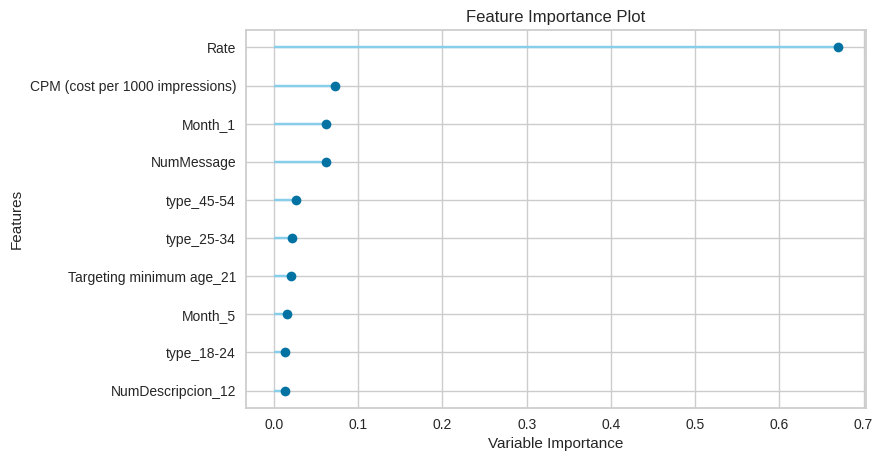

In [ ]:
#Feature Importance

plot_model(estimator = tuned_dt, plot = 'feature')

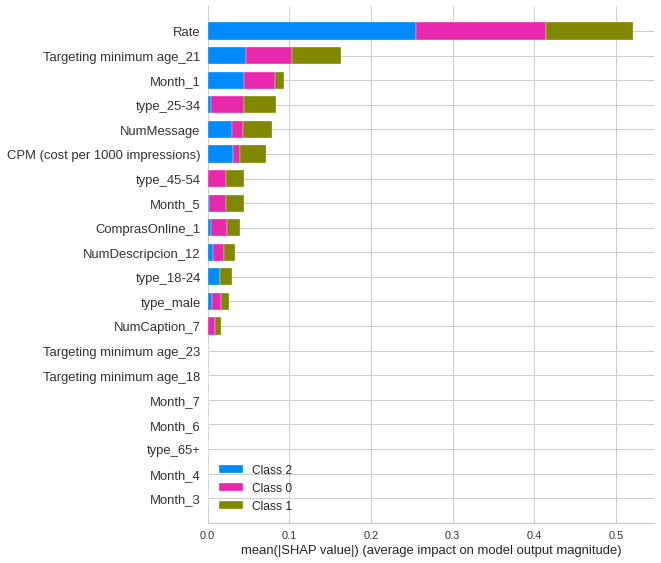

In [ ]:
#Interpretation
import shap

interpret_model(tuned_dt)
#This function only supports tree based models for binary classification: dt, lightgbm, et, rf.

In [ ]:
#Predecir
predict_model(tuned_dt, data=test)


,Month,Targeting minimum age,Targeting maximum age,CPM (cost per 1000 impressions),Clasificacion,NumDescripcion,NumMessage,NumCaption,Rate,ComprasOnline,Seguridad,SeguridadAlarmas,DispositivoInteligente,DispositivosGPS,SmartTechnologies,TarjetasCredito,Transporte,Vehiculos,type_female,type_male,type_18-24,type_25-34,type_35-44,type_45-54,type_55-64,type_65+,Label,Score
1518,4,21,65,2.35,2,12,30,7,0.004464,1,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,2,0.7000
1192,3,21,65,2.73,1,12,30,7,0.003020,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0.5000
1852,5,21,65,2.60,1,12,30,7,0.001838,1,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0.5000
2102,6,21,65,2.60,0,12,30,7,0.001016,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0.5000
632,2,21,65,1.22,2,5,39,4,0.001414,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0.9630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,4,23,44,2.47,1,12,30,7,0.001864,1,1,1,1,1,1,1,1,1,0,1,0,0,1,0,0,0,0,0.5600
2569,7,23,44,0.93,0,7,22,6,0.000381,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,0,0,1,0.7419
2826,7,23,55,1.26,0,7,22,6,0.000749,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0.7419
2390,6,25,65,7.22,2,6,23,4,0.017857,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,1,1.0000


In [ ]:
predictions = predict_model(tuned_dt, data=test)
predictions.head()

,Month,Targeting minimum age,Targeting maximum age,CPM (cost per 1000 impressions),Clasificacion,NumDescripcion,NumMessage,NumCaption,Rate,ComprasOnline,Seguridad,SeguridadAlarmas,DispositivoInteligente,DispositivosGPS,SmartTechnologies,TarjetasCredito,Transporte,Vehiculos,type_female,type_male,type_18-24,type_25-34,type_35-44,type_45-54,type_55-64,type_65+,Label,Score
1518,4,21,65,2.35,2,12,30,7,0.004464,1,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,2,0.700
1192,3,21,65,2.73,1,12,30,7,0.003020,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0.500
1852,5,21,65,2.60,1,12,30,7,0.001838,1,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0.500
2102,6,21,65,2.60,0,12,30,7,0.001016,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0.500
632,2,21,65,1.22,2,5,39,4,0.001414,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0.963


## 4.4.- Algoritmos utilizados

La ejecución de pycaret sirvió para establecer una linea base, para la exploración manual, de cada algoritmo constatando el resultado obtenido usando la librería de AutoML

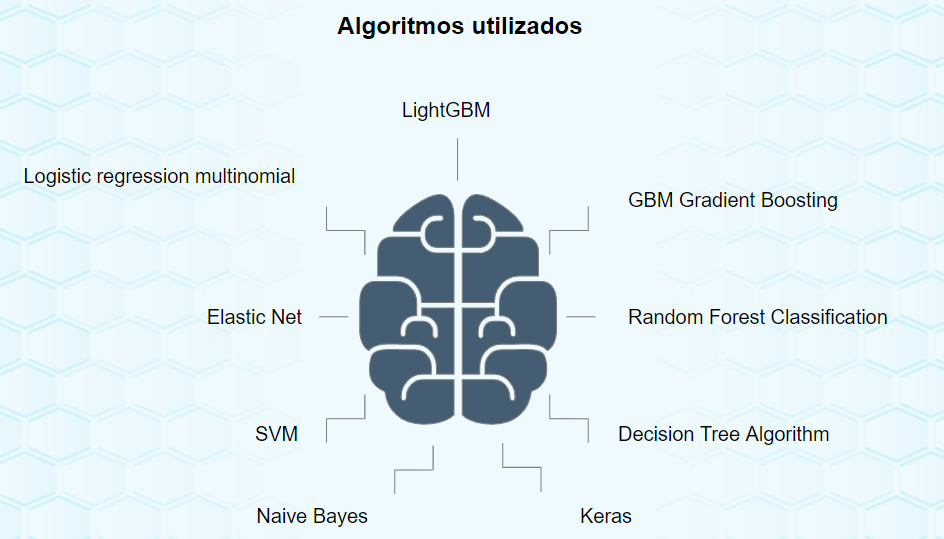

In [ ]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd 
import random
from sklearn.cluster import KMeans
#from yellowbrick.cluster import SilhouetteVisualizer
import datetime
import seaborn as sns
import math 
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt # plotting
import plotly.graph_objs as go
import plotly as py
import plotly.express as px
#from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.graph_objs as pgo
import sklearn.model_selection as model_selection
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import cross_val_score
import sklearn.model_selection as model_selection 
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_selector
from sklearn.naive_bayes import ComplementNB 
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from scipy.stats import uniform
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
!pip install sklearn-pandas
from sklearn_pandas import DataFrameMapper

Crear el dataset con las columnas que se usarás para el entrenamiento y el test


In [ ]:
print(x_train.columns)
x_temp =  x.drop(['Unique leads','Impressions', 'Reach', 'Link clicks','Cost','CTR','Cost per on-Facebook lead'],axis=1 )
x_train_cp = x_train.drop(['Unique leads','Impressions', 'Reach', 'Link clicks','Cost','CTR','Cost per on-Facebook lead'],axis=1 )
x_test_cp = x_test.drop(['Unique leads','Impressions', 'Reach', 'Link clicks','Cost','CTR','Cost per on-Facebook lead'],axis=1 )
print(x_temp.columns)
print(x_train_cp.columns)
print(x_test_cp.columns)

y_temp = y
print(y.shape)
print(y_train.shape)
print(y_test.shape)

Index(['Month', 'Targeting minimum age', 'Targeting maximum age', 'Cost',
       'Impressions', 'Reach', 'Link clicks', 'Unique leads',
       'CPM (cost per 1000 impressions)', 'Cost per on-Facebook lead',
       'NumDescripcion', 'NumMessage', 'NumCaption', 'Rate', 'CTR',
       'ComprasOnline', 'Seguridad', 'SeguridadAlarmas',
       'DispositivoInteligente', 'DispositivosGPS', 'SmartTechnologies',
       'TarjetasCredito', 'Transporte', 'Vehiculos', 'type_female',
       'type_male', 'type_18-24', 'type_25-34', 'type_35-44', 'type_45-54',
       'type_55-64', 'type_65+'],
      dtype='object')
Index(['Month', 'Targeting minimum age', 'Targeting maximum age',
       'CPM (cost per 1000 impressions)', 'NumDescripcion', 'NumMessage',
       'NumCaption', 'Rate', 'ComprasOnline', 'Seguridad', 'SeguridadAlarmas',
       'DispositivoInteligente', 'DispositivosGPS', 'SmartTechnologies',
       'TarjetasCredito', 'Transporte', 'Vehiculos', 'type_female',
       'type_male', 'type_18-24', '

Lista con las etiquetas que se usan

2 peor, 1 Regular y 0 bueno

In [ ]:
lista_etiquetas = [0,1,2]

Sacar una copia de los datos para obtener las etiquetas y los valores de las etiquetas

In [ ]:
x_total= x.copy()
x_total['y'] = y


In [ ]:
print(type(x_train_cp))
print(x_train_cp)

#X = data_original.drop('Clasificacion', axis=1)

<class 'pandas.core.frame.DataFrame'>
         Month  Targeting minimum age  ...  type_55-64  type_65+
2931  1.000000               0.000000  ...         0.0       0.0
2070  0.833333               0.428571  ...         0.0       0.0
1761  0.666667               0.428571  ...         0.0       0.0
716   0.166667               0.428571  ...         0.0       0.0
1309  0.500000               0.714286  ...         0.0       0.0
...        ...                    ...  ...         ...       ...
1041  0.333333               0.428571  ...         1.0       0.0
1814  0.666667               0.428571  ...         0.0       0.0
1911  0.833333               0.714286  ...         0.0       0.0
1612  0.500000               0.714286  ...         0.0       0.0
220   0.000000               0.428571  ...         0.0       0.0

[380 rows x 25 columns]


In [ ]:
print(type(x_test_cp))
print(x_test_cp)

<class 'pandas.core.frame.DataFrame'>
         Month  Targeting minimum age  ...  type_55-64  type_65+
2069  0.833333               0.428571  ...         0.0       0.0
42    0.000000               0.714286  ...         0.0       0.0
1512  0.500000               0.428571  ...         0.0       0.0
700   0.166667               0.428571  ...         0.0       0.0
539   0.166667               0.714286  ...         0.0       0.0
...        ...                    ...  ...         ...       ...
193   0.000000               0.428571  ...         0.0       0.0
1671  0.666667               0.714286  ...         0.0       0.0
2482  0.833333               0.714286  ...         0.0       0.0
559   0.166667               0.714286  ...         0.0       0.0
2271  0.833333               1.000000  ...         0.0       0.0

[96 rows x 25 columns]


In [ ]:
y_temp.shape

(476,)

para guardar el valor del accuracy para los diferentes modelo y de esta manera graficarlos para hacer una comparación

In [ ]:
accuracies = {}

El procedimiento de validación cruzada de k-fold es un método estándar para estimar el rendimiento de un algoritmo o configuración de aprendizaje automático en un conjunto de datos.
La validación cruzada repetida de k veces proporciona una forma de mejorar el rendimiento estimado de un modelo de aprendizaje automático
Esto implica simplemente repetir el procedimiento de validación cruzada varias veces e informar el resultado medio en todos los pliegues de todas las ejecuciones.
Se espera que este resultado medio sea una estimación más precisa del rendimiento medio subyacente real desconocido del modelo en el conjunto de datos, calculado utilizando el error estándar.
La validación cruzada repetida de k veces proporciona una forma de reducir el error en la estimación del rendimiento medio del modelo


In [ ]:
cv= RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=123)
cv



RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=123)

## 4.5.- Logistic regression multinomial



Una primera vista sobre un modelo de regresión multinomial sin usar un grid de  hiperparámetros para evaluar el mejor modelo

In [ ]:
# define the multinomial logistic regression model
model_lg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model_lg

LogisticRegression(multi_class='multinomial')

In [ ]:
lr = model_lg.fit(x_train_cp, y_train)

In [ ]:
# get modelo


acc = model_lg.score(x_test_cp,y_test)*100

accuracies['Logistic Regression'] = acc
print("Test Accuracy {:.2f}%".format(acc))

Test Accuracy 54.17%


In [ ]:
# get importance
importances = model_lg.coef_[0]

In [ ]:
# summarize feature importance
df_imp = pd.DataFrame({'feature':list(x_train_cp.columns), 'importance':importances})
df_imp.sort_values('importance', ascending=False,inplace=True)
df_imp[df_imp.importance >= 0.05 ].head(20)

,feature,importance
0,Month,1.538439
6,NumCaption,0.912460
2,Targeting maximum age,0.709489
4,NumDescripcion,0.702886
9,Seguridad,0.367967
21,type_35-44,0.277916
20,type_25-34,0.262191
10,SeguridadAlarmas,0.207397
23,type_55-64,0.206191
13,SmartTechnologies,0.201333


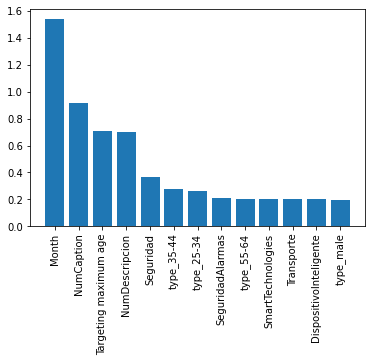

In [ ]:
plt.bar(df_imp[df_imp.importance >= 0.05 ].feature,df_imp[df_imp.importance >= 0.05 ].importance)
plt.xticks(rotation=90)
plt.show()


In [ ]:
model_lg.score(x_test_cp,y_test)

0.5416666666666666

In [ ]:
print( classification_report(y_test, model_lg.predict(x_test_cp)) )

              precision    recall  f1-score   support

           0       0.44      0.29      0.35        24
           1       0.54      0.73      0.62        48
           2       0.67      0.42      0.51        24

    accuracy                           0.54        96
   macro avg       0.55      0.48      0.49        96
weighted avg       0.55      0.54      0.53        96



Plot of a ROC over x_test_cp

In [ ]:
probabilidad = lr.predict_proba(x_test_cp)

In [ ]:
prediccion = lr.predict(x_temp)

In [ ]:
print(prediccion.shape)
print(x_temp.shape)
print(probabilidad.shape)
print(y_temp.shape)

(476,)
(476, 25)
(96, 3)
(476,)


In [ ]:

#probabilidad


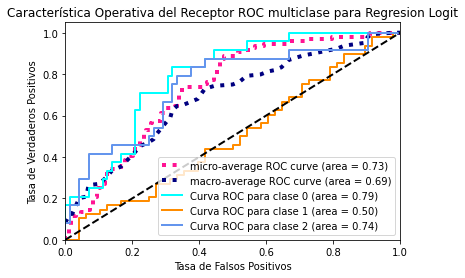

In [ ]:
grafica_roc_multiclase (y_test, probabilidad,  lista_etiquetas, 'Regresion Logit')

In [ ]:
import pickle
# Lets dump our rf_model
pickle.dump(lr, open('lr_model.pkl','wb'))

*******FIN VERSION ANTERIOR REGRESION LOGISTICA

In [ ]:
#lr.feature_importances
#https://machinelearningmastery.com/calculate-feature-importance-with-python/
#https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html


## 4.6.- Elastic Net

Ejecución de Elastic net con algunas de los hiperparámetros revisados en Clase

In [ ]:
enet_grid = dict(
C = [1e-9, 1e-5, 1e-1],
l1_ratio = [0.1, 0.5, 0.9] ) 
enet_grid

{'C': [1e-09, 1e-05, 0.1], 'l1_ratio': [0.1, 0.5, 0.9]}

In [ ]:
enet = LogisticRegression(penalty= 'elasticnet', solver= 'saga', max_iter=500)

In [ ]:
enet.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [ ]:
clf = GridSearchCV(enet, param_grid= enet_grid, cv=cv, n_jobs=-1)

In [ ]:
best_model_enet = clf.fit(x_train_cp, y_train)

In [ ]:

acc = best_model_enet.best_estimator_.score(x_test_cp,y_test)*100
accuracies['enet'] = acc
print("Test Accuracy of Elastic net Algorithm: {:.2f}%".format(acc))

Test Accuracy of Elastic net Algorithm: 51.04%


In [ ]:
# get importance
importances =  best_model_enet.best_estimator_.coef_[0]

enet_best = best_model_enet.best_estimator_


In [ ]:
# summarize feature importance
df_imp = pd.DataFrame({'feature':list(x_train_cp.columns), 'importance':importances})
df_imp.sort_values('importance', ascending=False,inplace=True)
df_imp[df_imp.importance >= 0.05 ].head(10)


,feature,importance
0,Month,0.669634
6,NumCaption,0.542591
4,NumDescripcion,0.260638
21,type_35-44,0.097315
18,type_male,0.064613
9,Seguridad,0.054832


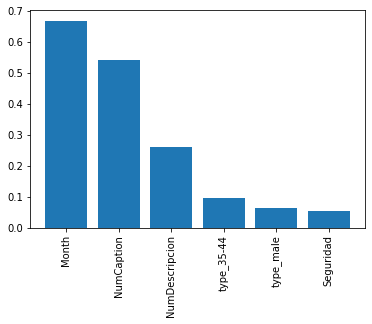

In [ ]:
# plot feature importance
plt.bar(df_imp[df_imp.importance >= 0.05 ].feature,df_imp[df_imp.importance >= 0.05 ].importance)
plt.xticks(rotation=90)
plt.show()

In [ ]:
print( classification_report(y_test, best_model_enet.best_estimator_.predict(x_test_cp)) )

              precision    recall  f1-score   support

           0       0.33      0.04      0.07        24
           1       0.51      0.94      0.66        48
           2       0.75      0.12      0.21        24

    accuracy                           0.51        96
   macro avg       0.53      0.37      0.32        96
weighted avg       0.52      0.51      0.40        96



In [ ]:

probabilidad = enet_best.predict_proba(x_test_cp)



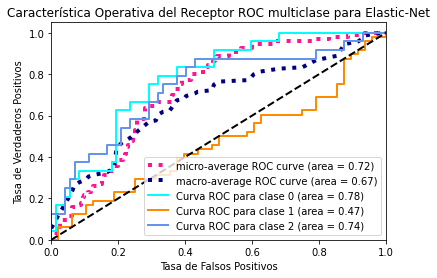

In [ ]:
grafica_roc_multiclase (y_test, probabilidad,  lista_etiquetas, 'Elastic-Net')

In [ ]:
import pickle
# Lets dump our rf_model
pickle.dump(enet_best, open('enet_model.pkl','wb'))

## 4.7.- Logistic regression multinomial con Tunning Hyperparámetros

Usar un grid de hyperparametros para entrenar y sacar un modelo entrenado

In [ ]:
# define the multinomial logistic regression model
model_tunlg = LogisticRegression(multi_class='multinomial')
model_tunlg

#‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ 

LogisticRegression(multi_class='multinomial')

In [ ]:
# crear espacio de busqueda para 
# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)

solver = ['newton-cg','sag','saga','lbfgs']

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty, solver=solver)

scores = ['precision', 'recall']

In [ ]:
# Create randomized search 5-fold cross validation and 100 iterations
clf = RandomizedSearchCV(model_tunlg, hyperparameters, random_state=1, n_iter=100, cv=5, verbose=0, n_jobs=-1)

#clf = GridSearchCV(model_tunlg, hyperparameters, random_state=1, n_iter=100, cv=5, verbose=0, n_jobs=-1)

In [ ]:
# Fit randomized search
best_model_lg = clf.fit(x_train_cp, y_train)

In [ ]:
# View best hyperparameters
print('Best Penalty:', best_model_lg.best_estimator_.get_params()['penalty'])
print('Best C:', best_model_lg.best_estimator_.get_params()['C'])
print('Best solver:', best_model_lg.best_estimator_.get_params()['solver'])

Best Penalty: l2
Best C: 0.6793216782582756
Best solver: newton-cg


In [ ]:
# Predict target vector
best_model_lg.predict(x_test_cp)

array([1, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 2, 0, 1, 1, 2, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 2, 1, 2, 0, 2, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       1, 0, 1, 1, 1, 1, 1, 0])

In [ ]:
acc = best_model_lg.score(x_test_cp,y_test)*100
accuracies['best_model_lg'] = acc
print("Test Accuracy of Logistict Tunned Algorithm: {:.2f}%".format(acc))

Test Accuracy of Logistict Tunned Algorithm: 52.08%


In [ ]:
# get importance
importances = best_model_lg.best_estimator_.coef_[0]

In [ ]:
# summarize feature importance
df_imp = pd.DataFrame({'feature':list(x_train_cp.columns), 'importance':importances})
df_imp.sort_values('importance', ascending=False,inplace=True)
df_imp[df_imp.importance >= 0.05 ].head(30)


,feature,importance
0,Month,1.409202
6,NumCaption,0.884971
4,NumDescripcion,0.640983
2,Targeting maximum age,0.568495
9,Seguridad,0.283021
21,type_35-44,0.254654
20,type_25-34,0.237646
23,type_55-64,0.195824
18,type_male,0.191199
11,DispositivoInteligente,0.169253


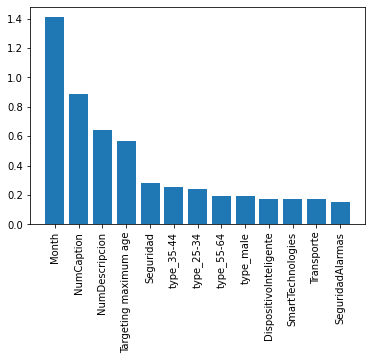

In [ ]:
# plot feature importance
plt.bar(df_imp[df_imp.importance >= 0.05 ].feature,df_imp[df_imp.importance >= 0.05 ].importance)
plt.xticks(rotation=90)
plt.show()

In [ ]:
print( classification_report(y_test, best_model_lg.best_estimator_.predict(x_test_cp)) )

              precision    recall  f1-score   support

           0       0.44      0.29      0.35        24
           1       0.52      0.73      0.61        48
           2       0.62      0.33      0.43        24

    accuracy                           0.52        96
   macro avg       0.53      0.45      0.46        96
weighted avg       0.52      0.52      0.50        96



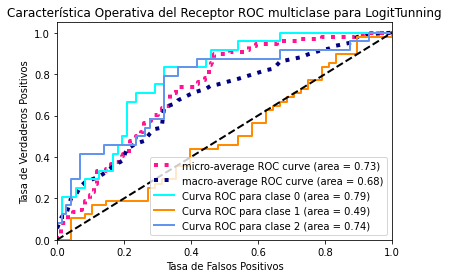

In [ ]:
blg = best_model_lg.best_estimator_

probabilidad = blg.predict_proba(x_test_cp)
grafica_roc_multiclase (y_test, probabilidad,  lista_etiquetas, 'LogitTunning')


In [ ]:
import pickle
# Lets dump our rf_model
pickle.dump(blg, open('blg.pkl','wb'))

## 4.8.- Support Vector Machine (SVM) Algorithm


In [ ]:
# crear espacio de busqueda para 
# Create regularization penalty space
kernel = ['linear', 'poly', 'rbf' ,'sigmoid' 'precomputed']
# Create regularization hyperparameter distribution using uniform distribution
C = [1, 10, 100]


# Create hyperparameter options
hyperparameters = dict(C=C, kernel=kernel)

In [ ]:
svm = SVC( gamma='scale',decision_function_shape='ovr',probability=True)

In [ ]:
# Create randomized search 5-fold cross validation and 100 iterations
#clf = RandomizedSearchCV(svm, hyperparameters, random_state=1, n_iter=100, cv=5, verbose=0, n_jobs=-1)

In [ ]:
clf = GridSearchCV(svm, param_grid= hyperparameters, cv=cv, n_jobs=-1)

In [ ]:
# Fit randomized search
best_model_svm = clf.fit(x_train_cp, y_train)

In [ ]:
# View best hyperparameters
print('Best kernel:', best_model_svm.best_estimator_.get_params()['kernel'])
print('Best C:', best_model_svm.best_estimator_.get_params()['C'])


Best kernel: linear
Best C: 100


In [ ]:
acc = best_model_svm.score(x_test_cp,y_test)*100
accuracies['svm'] = acc
print("Test Accuracy of Logistict Tunned Algorithm: {:.2f}%".format(acc))

Test Accuracy of Logistict Tunned Algorithm: 55.21%


In [ ]:
# get importance
importances = best_model_svm.best_estimator_.coef_[0]

# summarize feature importance
df_imp = pd.DataFrame({'feature':list(x_train_cp.columns), 'importance':importances})
df_imp.sort_values('importance', ascending=False,inplace=True)
df_imp[df_imp.importance >= 0.05 ].head(30)

,feature,importance
5,NumMessage,1.331992
9,Seguridad,0.928586
6,NumCaption,0.808331
2,Targeting maximum age,0.762380
10,SeguridadAlarmas,0.694468
16,Vehiculos,0.582083
23,type_55-64,0.443598
0,Month,0.425054
4,NumDescripcion,0.378106
12,DispositivosGPS,0.253134


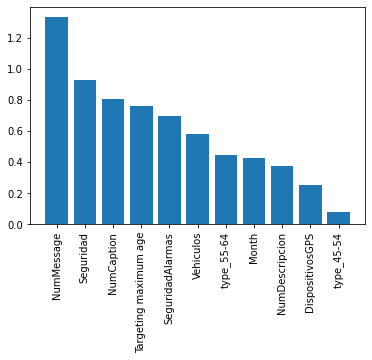

In [ ]:
# plot feature importance
plt.bar(df_imp[df_imp.importance >= 0.05 ].feature,df_imp[df_imp.importance >= 0.05 ].importance)
plt.xticks(rotation=90)
plt.show()

In [ ]:
print( classification_report(y_test, best_model_svm.best_estimator_.predict(x_test_cp)) )

              precision    recall  f1-score   support

           0       0.33      0.17      0.22        24
           1       0.55      0.85      0.67        48
           2       0.89      0.33      0.48        24

    accuracy                           0.55        96
   macro avg       0.59      0.45      0.46        96
weighted avg       0.58      0.55      0.51        96



Plot of a ROC

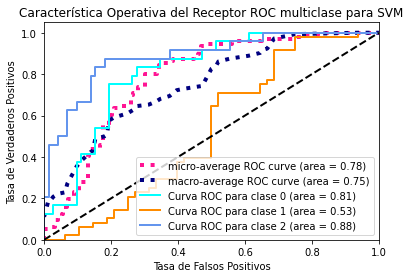

In [ ]:
svm_best = best_model_svm.best_estimator_

probabilidad = svm_best.predict_proba(x_test_cp)
grafica_roc_multiclase (y_test, probabilidad,  lista_etiquetas, 'SVM')


In [ ]:
import pickle
# Lets dump our rf_model
pickle.dump(svm_best, open('svm.pkl','wb'))

## 4.9- KNN

In [ ]:
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]

In [ ]:
# KNN Model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()  # n_neighbors means k


In [ ]:
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

In [ ]:
# Create randomized search 5-fold cross validation and 100 iterations
clf = RandomizedSearchCV(knn, hyperparameters, random_state=1, n_iter=100, cv=10, verbose=0, n_jobs=-1)

In [ ]:
# Fit randomized search
best_model_knn = clf.fit(x_train_cp, y_train)

In [ ]:
# View best hyperparameters
print('Best leaf_size:', best_model_knn.best_estimator_.get_params()['leaf_size'])
print('Best n_neighbors:', best_model_knn.best_estimator_.get_params()['n_neighbors'])
print('Best p:', best_model_knn.best_estimator_.get_params()['p'])


Best leaf_size: 12
Best n_neighbors: 28
Best p: 2


In [ ]:
acc = best_model_knn.score(x_test_cp,y_test)*100
accuracies['knn'] = acc
print("Test Accuracy of Logistict Tunned Algorithm: {:.2f}%".format(acc))

Test Accuracy of Logistict Tunned Algorithm: 48.96%


In [ ]:
# No hay features importances en KNN


In [ ]:
print( classification_report(y_test, best_model_knn.best_estimator_.predict(x_test_cp)) )

              precision    recall  f1-score   support

           0       0.25      0.08      0.12        24
           1       0.50      0.88      0.64        48
           2       0.75      0.12      0.21        24

    accuracy                           0.49        96
   macro avg       0.50      0.36      0.33        96
weighted avg       0.50      0.49      0.40        96



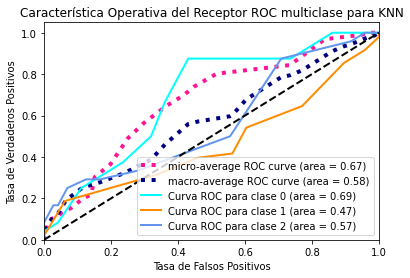

In [ ]:
knn3 = best_model_knn.best_estimator_

probabilidad = knn3.predict_proba(x_test_cp)
grafica_roc_multiclase (y_test, probabilidad,  lista_etiquetas, 'KNN')

In [ ]:
import pickle
# Lets dump our rf_model
pickle.dump(knn, open('knn3.pkl','wb'))

## 4.10- Naive Bayes

Encontramos este hiperparámetro a variar, suavizado
https://www.analyticsvidhya.com/blog/2021/01/gaussian-naive-bayes-with-hyperpameter-tuning/

In [ ]:
hyperparameters = {'var_smoothing': np.logspace(0,-9, num=100)}

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()


In [ ]:
# Create randomized search 5-fold cross validation and 100 iterations
clf = RandomizedSearchCV(nb, hyperparameters, random_state=1, n_iter=100, cv=10, verbose=0, n_jobs=-1)

In [ ]:
# Fit randomized search
best_model_nb = clf.fit(x_train_cp, y_train)

In [ ]:
# View best hyperparameters
print('Best var_smoothing:', best_model_nb.best_estimator_.get_params()['var_smoothing'])


Best var_smoothing: 1.232846739442066e-06


In [ ]:
acc = best_model_nb.score(x_test_cp,y_test)*100
accuracies['nb'] = acc
print("Test Accuracy of Logistict Tunned Algorithm: {:.2f}%".format(acc))

Test Accuracy of Logistict Tunned Algorithm: 58.33%


In [ ]:
print( classification_report(y_test, best_model_nb.best_estimator_.predict(x_test_cp)) )

              precision    recall  f1-score   support

           0       0.65      0.62      0.64        24
           1       0.57      0.73      0.64        48
           2       0.50      0.25      0.33        24

    accuracy                           0.58        96
   macro avg       0.58      0.53      0.54        96
weighted avg       0.57      0.58      0.56        96



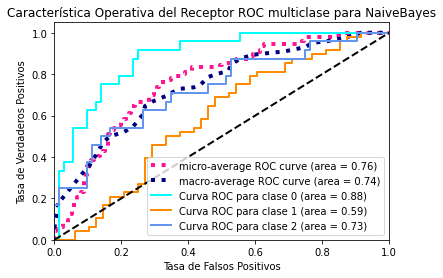

In [ ]:
nb = best_model_nb.best_estimator_

probabilidad = nb.predict_proba(x_test_cp)
grafica_roc_multiclase (y_test, probabilidad,  lista_etiquetas, 'NaiveBayes')

Grabar el modelo para algun tipo de back test

In [ ]:
import pickle
# Lets dump our rf_model
pickle.dump(nb, open('nb.pkl','wb'))

## 4.11.- Decision Tree Algorithm



In [ ]:

from matplotlib import pyplot
dtc = DecisionTreeClassifier(max_depth=3)


In [ ]:
# Create randomized search 5-fold cross validation and 100 iterations
#clf = RandomizedSearchCV(dtc, hyperparameters, random_state=1, n_iter=100, cv=10, verbose=0, n_jobs=-1)

In [ ]:
best_model_tree = dtc.fit(x_train_cp, y_train)



acc = best_model_tree.score(x_test_cp,y_test)*100
accuracies['tree'] = acc
print("Test Accuracy of Tree Tunned Algorithm: {:.2f}%".format(acc))

Test Accuracy of Tree Tunned Algorithm: 69.79%


[Text(193.15384615384616, 190.26, 'X[7] <= 0.007\ngini = 0.624\nsamples = 380\nvalue = [94, 191, 95]'),
 Text(103.01538461538462, 135.9, 'X[7] <= 0.002\ngini = 0.51\nsamples = 263\nvalue = [94, 158, 11]'),
 Text(51.50769230769231, 81.53999999999999, 'X[3] <= 0.017\ngini = 0.39\nsamples = 64\nvalue = [47, 17, 0]'),
 Text(25.753846153846155, 27.180000000000007, 'gini = 0.401\nsamples = 18\nvalue = [5, 13, 0]'),
 Text(77.26153846153846, 27.180000000000007, 'gini = 0.159\nsamples = 46\nvalue = [42, 4, 0]'),
 Text(154.52307692307693, 81.53999999999999, 'X[3] <= 0.076\ngini = 0.439\nsamples = 199\nvalue = [47, 141, 11]'),
 Text(128.76923076923077, 27.180000000000007, 'gini = 0.312\nsamples = 155\nvalue = [17, 127, 11]'),
 Text(180.27692307692308, 27.180000000000007, 'gini = 0.434\nsamples = 44\nvalue = [30, 14, 0]'),
 Text(283.2923076923077, 135.9, 'X[7] <= 0.017\ngini = 0.405\nsamples = 117\nvalue = [0, 33, 84]'),
 Text(257.53846153846155, 81.53999999999999, 'X[3] <= 0.065\ngini = 0.483\nsa

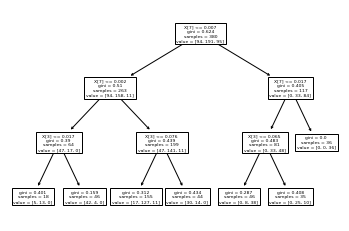

In [ ]:
from sklearn import tree

tree.plot_tree(best_model_tree.fit(x_train_cp, y_train)) 

In [ ]:
print( classification_report(y_test, best_model_tree.predict(x_test_cp)) )

              precision    recall  f1-score   support

           0       0.64      0.67      0.65        24
           1       0.69      0.73      0.71        48
           2       0.80      0.67      0.73        24

    accuracy                           0.70        96
   macro avg       0.71      0.69      0.70        96
weighted avg       0.70      0.70      0.70        96



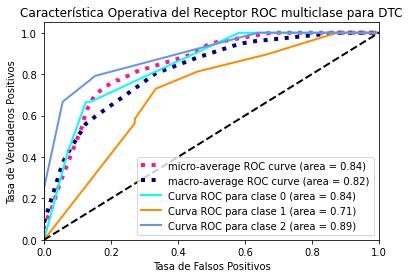

In [ ]:
dtc = best_model_tree

probabilidad = dtc.predict_proba(x_test_cp)
grafica_roc_multiclase (y_test, probabilidad,  lista_etiquetas, 'DTC')

In [ ]:
import pickle
# Lets dump our rf_model
pickle.dump(best_model_tree, open('dtc.pkl','wb'))

### Gini

In [ ]:
clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)


# fit the model
clf_gini.fit(x_train_cp, y_train)
acc = clf_gini.score(x_test_cp, y_test)*100
accuracies['Decision Tree gini'] = acc
print("Decision Tree Gini Test Accuracy {:.2f}%".format(acc))

#Compare the train-set and test-set accuracy

y_pred_gini = clf_gini.predict(x_test_cp)
y_pred_train_gini = clf_gini.predict(x_train_cp)
y_pred_train_gini

#Check for overfitting and underfitting
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf_gini.score(x_train_cp, y_train)))

print('Test set score: {:.4f}'.format(clf_gini.score(x_test_cp, y_test)))


Decision Tree Gini Test Accuracy 69.79%
Training set score: 0.8184
Test set score: 0.6979


[Text(193.15384615384616, 190.26, 'X[7] <= 0.007\ngini = 0.624\nsamples = 380\nvalue = [94, 191, 95]'),
 Text(103.01538461538462, 135.9, 'X[7] <= 0.002\ngini = 0.51\nsamples = 263\nvalue = [94, 158, 11]'),
 Text(51.50769230769231, 81.53999999999999, 'X[3] <= 0.017\ngini = 0.39\nsamples = 64\nvalue = [47, 17, 0]'),
 Text(25.753846153846155, 27.180000000000007, 'gini = 0.401\nsamples = 18\nvalue = [5, 13, 0]'),
 Text(77.26153846153846, 27.180000000000007, 'gini = 0.159\nsamples = 46\nvalue = [42, 4, 0]'),
 Text(154.52307692307693, 81.53999999999999, 'X[3] <= 0.076\ngini = 0.439\nsamples = 199\nvalue = [47, 141, 11]'),
 Text(128.76923076923077, 27.180000000000007, 'gini = 0.312\nsamples = 155\nvalue = [17, 127, 11]'),
 Text(180.27692307692308, 27.180000000000007, 'gini = 0.434\nsamples = 44\nvalue = [30, 14, 0]'),
 Text(283.2923076923077, 135.9, 'X[7] <= 0.017\ngini = 0.405\nsamples = 117\nvalue = [0, 33, 84]'),
 Text(257.53846153846155, 81.53999999999999, 'X[3] <= 0.065\ngini = 0.483\nsa

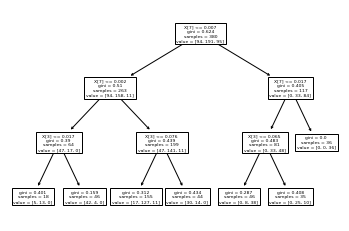

In [ ]:
# Visualize decision-trees


from sklearn import tree

tree.plot_tree(clf_gini.fit(x_train_cp, y_train)) 

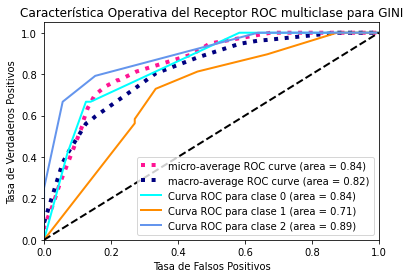

In [ ]:


probabilidad = clf_gini.predict_proba(x_test_cp)
grafica_roc_multiclase (y_test, probabilidad,  lista_etiquetas, 'GINI')

In [ ]:
import pickle
# Lets dump our rf_model
pickle.dump(clf_gini, open('gini.pkl','wb'))

### Entropy

In [ ]:

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# instantiate the DecisionTreeClassifier model with criterion entropy

clf_en = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)


# fit the model
clf_en.fit(x_train_cp, y_train)

#Predict the Test set results with criterion entropy
y_pred_en = clf_en.predict(x_test_cp)

#Check accuracy score with criterion entropy
print('Model accuracy score with criterion entropy: {0:0.4f}'. format(accuracy_score(y_test, y_pred_en)))

y_pred_train_en = clf_en.predict(x_train_cp)

y_pred_train_en
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_en)))

#Check for overfitting and underfitting

print('Training set score: {:.4f}'.format(clf_en.score(x_train_cp, y_train)))

print('Test set score: {:.4f}'.format(clf_en.score(x_test_cp, y_test)))

Model accuracy score with criterion entropy: 0.7292
Training-set accuracy score: 0.7684
Training set score: 0.7684
Test set score: 0.7292


In [ ]:
accuracies['entropy'] = clf_en.score(x_test_cp, y_test) * 100


[Text(386.3076923076923, 380.52, 'X[7] <= 0.006\nentropy = 1.497\nsamples = 380\nvalue = [94, 191, 95]'),
 Text(206.03076923076924, 271.8, 'X[7] <= 0.003\nentropy = 1.131\nsamples = 254\nvalue = [94, 152, 8]'),
 Text(103.01538461538462, 163.07999999999998, 'X[3] <= 0.047\nentropy = 0.987\nsamples = 129\nvalue = [73, 56, 0]'),
 Text(51.50769230769231, 54.360000000000014, 'entropy = 0.993\nsamples = 102\nvalue = [46, 56, 0]'),
 Text(154.52307692307693, 54.360000000000014, 'entropy = 0.0\nsamples = 27\nvalue = [27, 0, 0]'),
 Text(309.04615384615386, 163.07999999999998, 'X[3] <= 0.076\nentropy = 0.979\nsamples = 125\nvalue = [21, 96, 8]'),
 Text(257.53846153846155, 54.360000000000014, 'entropy = 0.561\nsamples = 95\nvalue = [2, 85, 8]'),
 Text(360.55384615384617, 54.360000000000014, 'entropy = 0.948\nsamples = 30\nvalue = [19, 11, 0]'),
 Text(566.5846153846154, 271.8, 'X[7] <= 0.017\nentropy = 0.893\nsamples = 126\nvalue = [0, 39, 87]'),
 Text(515.0769230769231, 163.07999999999998, 'X[3] <

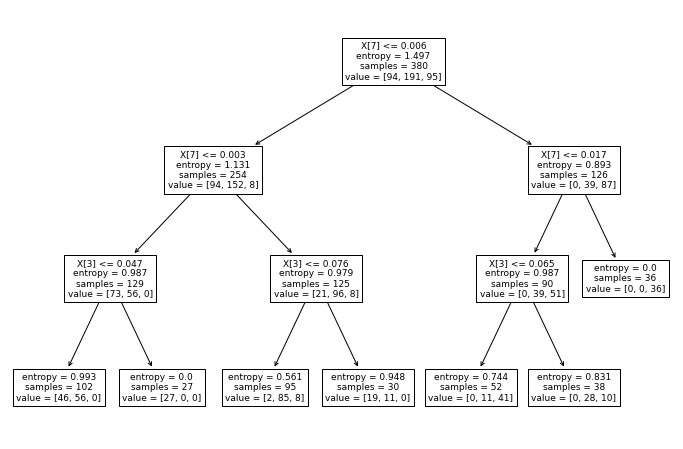

In [ ]:
#Visualize decision-trees

plt.figure(figsize=(12,8))

from sklearn import tree

tree.plot_tree(clf_en.fit(x_train_cp, y_train)) 

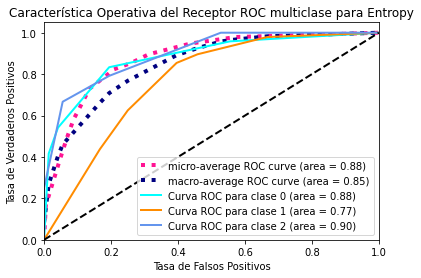

In [ ]:

probabilidad = clf_en.predict_proba(x_test_cp)
grafica_roc_multiclase (y_test, probabilidad,  lista_etiquetas, 'Entropy')

In [ ]:
import pickle
# Lets dump our rf_model
pickle.dump(clf_en, open('entropy.pkl','wb'))

Bibliografia
https://www.kaggle.com/prashant111/decision-tree-classifier-tutorial

## 4.12.-Random Forest Classification

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [ ]:
from sklearn.feature_selection import RFECV

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [ ]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
               


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
clf = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 10, verbose=2, random_state=42, n_jobs = -1)

best_model_rf = RFECV(clf, step=1)


In [ ]:
# Fit randomized search
best_model_rf = clf.fit(x_train_cp, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 24.3min finished


In [ ]:
acc = best_model_rf.score(x_test_cp,y_test)*100
accuracies['rf'] = acc
print("Test Accuracy of Logistict Tunned Algorithm: {:.2f}%".format(acc))

Test Accuracy of Logistict Tunned Algorithm: 79.17%


In [ ]:
#los mejores parametros
best_model_rf.best_params_

{'bootstrap': False,
 'max_depth': 70,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 600}

In [ ]:
print( classification_report(y_test, best_model_rf.best_estimator_.predict(x_test_cp)) )

              precision    recall  f1-score   support

           0       0.89      0.67      0.76        24
           1       0.76      0.85      0.80        48
           2       0.79      0.79      0.79        24

    accuracy                           0.79        96
   macro avg       0.81      0.77      0.79        96
weighted avg       0.80      0.79      0.79        96



Para sacar los features (característias) importantes

https://github.com/scikit-learn/scikit-learn/issues/4945

In [ ]:
# get importance
importances = best_model_rf.best_estimator_.feature_importances_

# summarize feature importance
df_imp = pd.DataFrame({'feature':list(x_train_cp.columns), 'importance':importances})
df_imp.sort_values('importance', ascending=False,inplace=True)
df_imp[df_imp.importance >= 0.01 ].head(30)

,feature,importance
7,Rate,0.482415
3,CPM (cost per 1000 impressions),0.143130
0,Month,0.073222
5,NumMessage,0.059900
6,NumCaption,0.045896
4,NumDescripcion,0.035973
21,type_35-44,0.015700
20,type_25-34,0.013897
2,Targeting maximum age,0.013270
19,type_18-24,0.012948


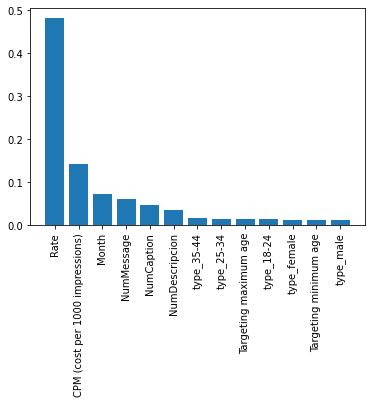

In [ ]:
# plot feature importance
plt.bar(df_imp[df_imp.importance >= 0.01 ].feature,df_imp[df_imp.importance >= 0.01 ].importance)
plt.xticks(rotation=90)
plt.show()

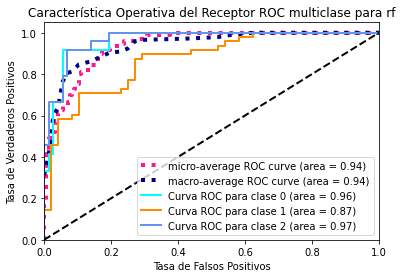

In [ ]:
rf_model = best_model_rf.best_estimator_
lista_etiquetas = best_model_rf.best_estimator_.classes_

probabilidad = rf_model.predict_proba(x_test_cp)
grafica_roc_multiclase (y_test, probabilidad,  lista_etiquetas, 'rf')



In [ ]:
import pickle
# Lets dump our rf_model
pickle.dump(rf_model, open('rf.pkl','wb'))

## 4.13.-GBC Gradient Boosting (Clasificador)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
hyperparameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 2,12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 1, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
}

In [ ]:
gbc = GradientBoostingClassifier()

In [ ]:
#clf = RandomizedSearchCV(estimator = gbc, param_distributions = hyperparameters, n_iter = 100, cv = 10, verbose=2, random_state=42, n_jobs = -1)
clf = GridSearchCV(estimator = gbc, param_grid= hyperparameters,  cv=cv, n_jobs=-1)

In [ ]:
# Fit randomized search
best_model_gbc = clf.fit(x_train_cp, y_train)

In [ ]:
best_model_gbc.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.2,
 'loss': 'deviance',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.1,
 'n_estimators': 10,
 'subsample': 0.8}

In [ ]:
acc = best_model_gbc.score(x_test_cp,y_test)*100
accuracies['gbc'] = acc
print("Test Accuracy of Logistict Tunned Algorithm: {:.2f}%".format(acc))

Test Accuracy of Logistict Tunned Algorithm: 66.67%


In [ ]:
#los mejores parametros
best_model_gbc.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.2,
 'loss': 'deviance',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.1,
 'n_estimators': 10,
 'subsample': 0.8}

In [ ]:
# get importance
importances = best_model_gbc.best_estimator_.feature_importances_

# summarize feature importance
df_imp = pd.DataFrame({'feature':list(x_train_cp.columns), 'importance':importances})
df_imp.sort_values('importance', ascending=False,inplace=True)
df_imp[df_imp.importance >= 0.01 ].head(30)

,feature,importance
7,Rate,0.687506
0,Month,0.089862
5,NumMessage,0.063090
3,CPM (cost per 1000 impressions),0.051434
6,NumCaption,0.037930
4,NumDescripcion,0.015527


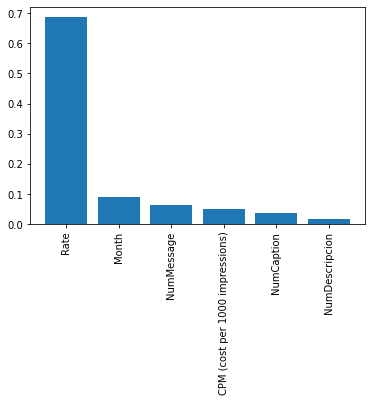

In [ ]:
# plot feature importance
plt.bar(df_imp[df_imp.importance >= 0.01 ].feature,df_imp[df_imp.importance >= 0.01 ].importance)
plt.xticks(rotation=90)
plt.show()

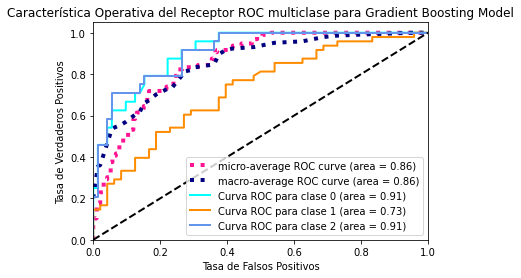

In [ ]:
gbc = best_model_gbc.best_estimator_
probabilidad = gbc.predict_proba(x_test_cp)
grafica_roc_multiclase (y_test, probabilidad,  lista_etiquetas, 'Gradient Boosting Model')

In [ ]:
# para version 3.8 windows
# https://www.codegrepper.com/code-examples/python/how+to+install+pickle+in+python+3.8
import pickle
# Lets dump our rf_model
pickle.dump(gbc, open('gbc.pkl','wb'))

## 4.14.-Keras

In [ ]:
import tensorflow as tf
def build_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=[len(x_train_cp.keys())]),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(2, activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
  ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

neural_model = build_model()


In [ ]:
neural_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 8)                 208       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 3         
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Keeping EPOCHs high as dataset is small.
EPOCHS = 100
neural_pred = neural_model.fit(x_train_cp, y_train,epochs=EPOCHS, validation_split=0.1, verbose=2)

Epoch 1/100
11/11 - 1s - loss: 0.2347 - accuracy: 0.4971 - val_loss: 0.2061 - val_accuracy: 0.5526
Epoch 2/100
11/11 - 0s - loss: 0.0476 - accuracy: 0.4971 - val_loss: 0.2034 - val_accuracy: 0.5526
Epoch 3/100
11/11 - 0s - loss: -3.4730e-02 - accuracy: 0.4971 - val_loss: 0.2129 - val_accuracy: 0.5526
Epoch 4/100
11/11 - 0s - loss: -1.2236e-01 - accuracy: 0.4971 - val_loss: 0.2205 - val_accuracy: 0.5526
Epoch 5/100
11/11 - 0s - loss: -2.1517e-01 - accuracy: 0.4971 - val_loss: 0.2280 - val_accuracy: 0.5526
Epoch 6/100
11/11 - 0s - loss: -3.9225e-01 - accuracy: 0.4971 - val_loss: 0.2372 - val_accuracy: 0.5526
Epoch 7/100
11/11 - 0s - loss: -6.5268e-01 - accuracy: 0.4971 - val_loss: 0.1841 - val_accuracy: 0.5526
Epoch 8/100
11/11 - 0s - loss: -1.0758e+00 - accuracy: 0.4971 - val_loss: 0.0933 - val_accuracy: 0.5526
Epoch 9/100
11/11 - 0s - loss: -1.7420e+00 - accuracy: 0.4971 - val_loss: 0.1830 - val_accuracy: 0.5526
Epoch 10/100
11/11 - 0s - loss: -2.7684e+00 - accuracy: 0.4971 - val_loss:

In [ ]:
_, acc = neural_model.evaluate(x_test_cp, y_test,
                            batch_size=64)
acc = acc *100
accuracies['Keras'] = acc
print("Keras Algorithm Accuracy Score : {:.2f}%".format(acc))

2/2 [==============================] - 0s 5ms/step - loss: -266834.5312 - accuracy: 0.5000
Keras Algorithm Accuracy Score : 50.00%


Plot of a ROC

In [ ]:
prediccion  = neural_pred.model.predict(x_test_cp, batch_size=32, verbose=0)

In [ ]:
np.reshape(prediccion,96)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.89139056, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.89139056, 1.        , 1.        , 0.89139056, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [ ]:
x_test_cp.shape

(96, 25)

## 4.15.-LightGBM

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

In [ ]:
import lightgbm as lgb
import pickle
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score

In [ ]:
param_grid = {
    'colsample_bytree': [0.1,0.7, 0.8],
    'max_depth': [10,20,30],
    'metric':['multi_logloss'],
    'objective':['multiclass'],
    'boosting_type':['gbdt'],
    'learning_rate':[0.03,0.05,0.07],
    'num_class':[3]
}

In [ ]:
model = lgb.LGBMClassifier()

In [ ]:
clf = GridSearchCV(estimator = model, param_grid= param_grid,  cv=cv, n_jobs=-1)

In [ ]:
# Fit randomized search
best_model_lgbc = clf.fit(x_train_cp, y_train)

In [ ]:
best_model_lgbc.best_params_

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.8,
 'learning_rate': 0.05,
 'max_depth': 10,
 'metric': 'multi_logloss',
 'num_class': 3,
 'objective': 'multiclass'}

In [ ]:
#Converting the dataset in proper LGB format
#d_train=lgb.Dataset(x_train_cp, label=y_train)

best_model_lgbc.best_estimator_

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=10,
               metric='multi_logloss', num_class=3, objective='multiclass')

In [ ]:
#clf=lgb.train(params,d_train,100)  #training the model on 100 epocs


In [ ]:
#prediction on the test dataset
probabilidad=clf.predict(x_test_cp)
probabilidad

array([0, 1, 1, 2, 2, 0, 0, 0, 1, 0, 1, 1, 2, 1, 1, 1, 0, 0, 2, 2, 2, 1,
       1, 0, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       2, 0, 2, 1, 0, 2, 0, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 2, 0, 0, 2, 2, 1, 1, 0, 2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2,
       0, 1, 1, 2, 2, 0, 2, 1])

In [ ]:
#argmax() method 
#y_pred_lgbm = [np.argmax(line) for line in probabilidad]
#type(y_pred_lgbm)
#y_pred_lgbm = np.array(y_pred_lgbm)
#y_pred_lgbm

In [ ]:
#acc = best_model_gbc.score(x_test_cp,y_test)*100
#using precision score for error metrics
#acc = precision_score(y_pred_lgbm,y_test,average=None).mean() *100
#acc = precision_score(probabilidad,y_test,average=None).mean() *100
#accuracies['lgbm'] = acc
#print("Test Accuracy of LGBM Tunned Algorithm: {:.2f}%".format(acc))



In [ ]:
lgbm =  best_model_lgbc.best_estimator_

In [ ]:
acc = lgbm.score(x_test_cp,y_test)*100
accuracies['lgbc'] = acc
print("Test Accuracy of LightGBM : {:.2f}%".format(acc))

Test Accuracy of LightGBM : 79.17%


In [ ]:

# get importance
importances = lgbm.feature_importances_

# summarize feature importance
df_imp = pd.DataFrame({'feature':list(x_train_cp.columns), 'importance':importances})
df_imp.sort_values('importance', ascending=False,inplace=True)
df_imp[df_imp.importance >= 0.01 ].head(30)



,feature,importance
7,Rate,1201
3,CPM (cost per 1000 impressions),1085
0,Month,422
5,NumMessage,329
6,NumCaption,320
4,NumDescripcion,188
2,Targeting maximum age,112
1,Targeting minimum age,95
20,type_25-34,51
9,Seguridad,49


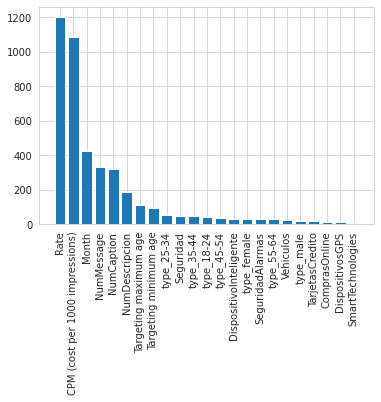

In [ ]:
# plot feature importance
plt.bar(df_imp[df_imp.importance >= 0.01 ].feature,df_imp[df_imp.importance >= 0.01 ].importance)
plt.xticks(rotation=90)
plt.show()

In [ ]:
print( classification_report(y_test, best_model_lgbc.best_estimator_.predict(x_test_cp)) )

              precision    recall  f1-score   support

           0       0.81      0.71      0.76        24
           1       0.78      0.81      0.80        48
           2       0.80      0.83      0.82        24

    accuracy                           0.79        96
   macro avg       0.80      0.78      0.79        96
weighted avg       0.79      0.79      0.79        96



In [ ]:
probabilidad = lgbm.predict_proba(x_test_cp)

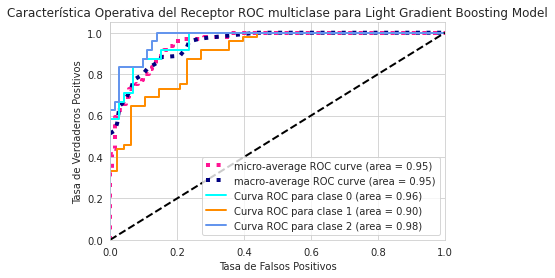

In [ ]:
probabilidad = best_model_lgbc.best_estimator_.predict_proba(x_test_cp)
grafica_roc_multiclase (y_test, probabilidad,  lista_etiquetas, 'Light Gradient Boosting Model')

Grabar el modelo ganador en pickle para usarlo en el Dashboard en Dash.

In [ ]:
# para version 3.8 windows
# https://www.codegrepper.com/code-examples/python/how+to+install+pickle+in+python+3.8
import pickle
# Lets dump our rf_model
pickle.dump(lgbm , open('lgbc.pkl','wb'))

# 5.- Comparacion de modelos y eleccion del mejor

In [ ]:
colors = ["purple", "green", "orange", "magenta","#CFC60E","#0FBBAE","blue","yellow","brown","lightblue"]

#pasarlo el diccionario a pandas para manejarlo mejor
pd_df = pd.DataFrame(list(accuracies.items()))
pd_df.columns =["Accuracies","Value"]
pd_df.sort_values('Value', ascending=False,inplace=True)
print (pd_df)


sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
ax = sns.barplot(x=pd_df['Accuracies'], y=pd_df['Value'], palette=colors)
ax.set(xlabel="Algoritmos", ylabel='"Accuracy %"')
ax.set_xticklabels(pd_df.Accuracies)
plt.yticks(np.arange(0,100,10))
for i, v in enumerate(pd_df["Value"].iteritems()):        
    ax.text(i ,v[1], "{:.2f}%".format(v[1]), color='m', va ='bottom', rotation=45)
plt.tight_layout()
#{:.2f}%
plt.show()

Grabar el modelo ganador en pickle para usarlo en el Dashboard en Dash.

8.- Matrix de confusion 

In [ ]:
# Predicted values
y_head_lr = lr.predict(x_test_cp)
knn3 = KNeighborsClassifier(n_neighbors = 3)
knn3.fit(x_train_cp, y_train)
y_head_knn = knn3.predict(x_test_cp)
y_head_svm = svm_best.predict(x_test_cp)
y_head_nb = nb.predict(x_test_cp)
y_head_dtc = dtc.predict(x_test_cp)
y_head_rf = rf_model.predict(x_test_cp)
y_head_lgbm = lgbm.predict(x_test_cp)

In [ ]:
from sklearn.metrics import confusion_matrix
cm_lr = confusion_matrix(y_test,y_head_lr)
cm_knn = confusion_matrix(y_test,y_head_knn)
cm_svm = confusion_matrix(y_test,y_head_svm)
cm_nb = confusion_matrix(y_test,y_head_nb)
cm_dtc = confusion_matrix(y_test,y_head_dtc)
cm_rf = confusion_matrix(y_test,y_head_rf)
cm_lgbm = confusion_matrix(y_test,y_head_lgbm)

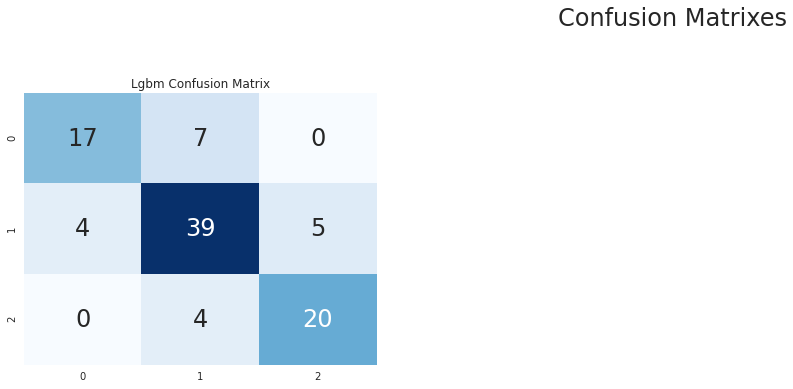

In [ ]:
plt.figure(figsize=(24,12))

plt.suptitle("Confusion Matrixes",fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(2,3,1)
plt.title("Lgbm Confusion Matrix")
sns.heatmap(cm_lgbm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})


plt.show()

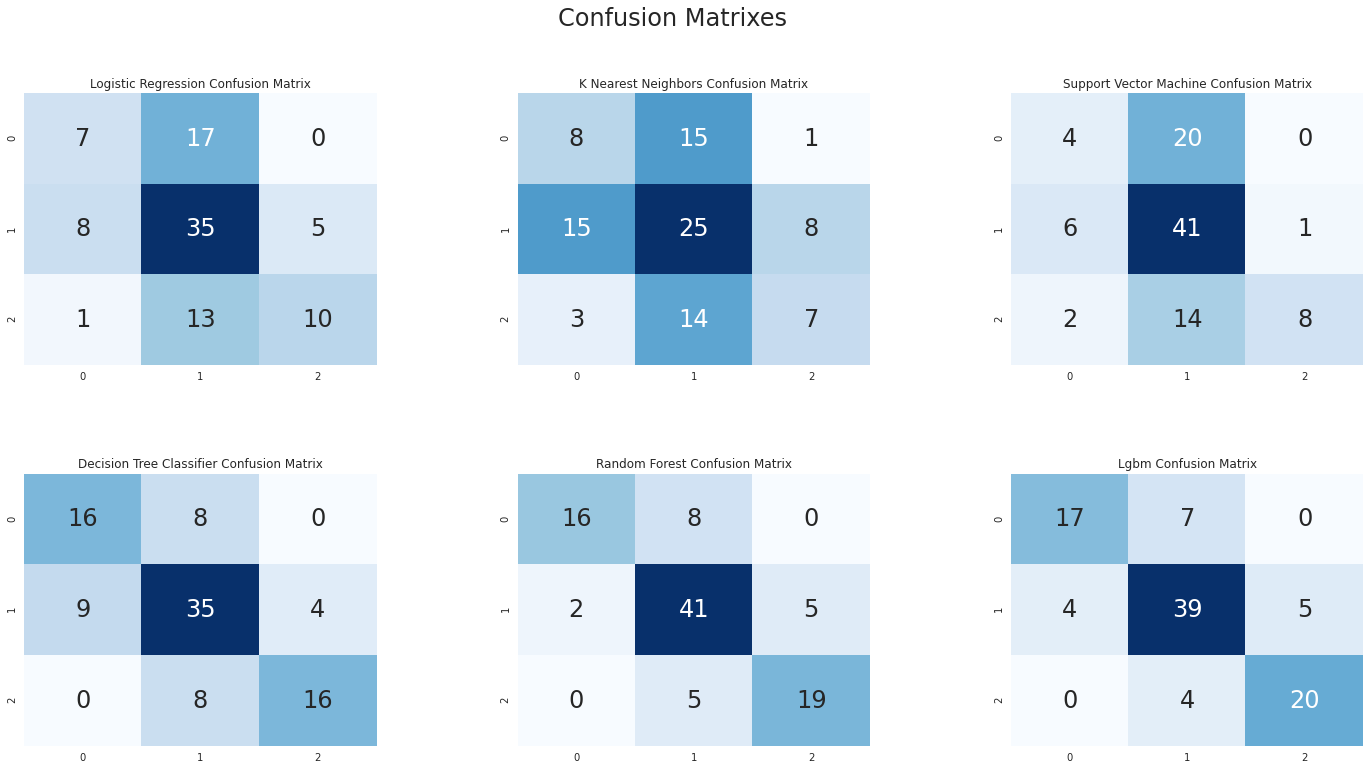

In [ ]:
plt.figure(figsize=(24,12))

plt.suptitle("Confusion Matrixes",fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(2,3,1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,2)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,3)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(cm_svm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,4)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_dtc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,5)
plt.title("Random Forest Confusion Matrix")
sns.heatmap(cm_rf,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,6)
plt.title("Lgbm Confusion Matrix")
sns.heatmap(cm_lgbm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

# 6.- Conclusiones

Se realizó a priori un proceso de clusterización con el objetivo de hallar segmentos de usuarios y, como  resultado de tal análisis éstos no se agruparon correctamente. Posteriormente, se aplicaron modelos de clasificación dado que para llegar a tener más leads (mejores anuncios) debemos detectar anuncios a un menor costo.

Los principales hallazgos son:

* El menor costo por leads fue generado en mujeres y en rangos de edades tales como: 18-24, 25-34 y de 35-44.

* Los mejores anuncios deben contener entre 20 a 30 palabras en el message o copy y 4 palabras en el título

* Eliminamos variables que ocasionaron overfitting como el “costo por leads”.

* Los dos algoritmos mejor ubicados según el accuracy  son: Light Gradient Boosting y Random forest, las variables de importancia fueron: Rate(#leads/#personas alcanzadas).

* Las stopwords en cada grupo de anuncios son similares con la única diferencia en “Mejores anuncios”, donde que la palabra “tú” ocupa el segundo lugar.

* Las palabras usadas en los los message de los mejores anuncios, regulares y peores difieren mucho entre sí.


#7.- Próximos pasos


* Realizar estudios por provincias o plataforma.
* Mejorar el procedimiento para evaluar los modelos.
* Aplicar otras técnicas como Ensamblado de modelos, otras tipologías de Redes Neuronales
* Implementación o puesta en producción.
* Análisis de sentimientos


# 8.- Bibliografia

https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert

https://sci2lab.github.io/ml_tutorial/tfidf/

https://www.kaggle.com/baguette059/machine-learning

https://www.kaggle.com/cinthyavergara/nltk-sentiment-and-segmentation-analysis-comments

https://www.kaggle.com/baguette059/machine-learning

https://towardsdatascience.com end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2

https://www.kaggle.com/niklasdonges/end-to-end-project-with-python
https://github.com/see-ecuador/MLProductivo/blob/main/diabetes.ipynb

https://towardsdatascience.com/multiclass-classification-with-support-vector-machines-svm-kernel-trick-kernel-functions-f9d5377d6f02

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

https://www.kaggle.com/cinthyavergara/nltk-sentiment-and-segmentation-analysis-comments

https://buhrmann.github.io/tfidf-analysis.html
